## Base Notebook

This notebook takes us up to the preprocessing pipeline. From there you can try out different models for the target class ('roadSurface'), or just work more on the ones Andre and I've been experimenting with. 

Here are some notes on decisions I have made at different stages in this notebook (let us know in the group chat if you want to make any changes to these steps or have any feedback/concerns):

**Target Class**
- I've used `roadSurface` as the target class. There doesn't seem to be much of a difference between this category and `traffic`, apart from `roadSurface` having a slightly better balance between the classes, and its minority class ('FullofHolesCondition') might be easier to predict than `traffic`'s smallest class as it's more correlated with other variables.  I think the main thing is that we all work on the same target class to begin with, and we can always try a different target class later on if we have extra time.

**Missing Values**
- There aren't that many missing values thankfully, and I've just used SimpleImputer(strategy = 'median') in the preprocessing pipeline to deal with them. 
- Orginally I had filled in the missing values with the average of the values of the previous and next non-missing rows, but this has to be done before splitting the dataset into train and test splits and I think in general preprocessing steps like this should be done after splitting the data to prevent data leakage so I decided to use a different method. 
- There are other options we could try out (KNN imputer, iterativeimputer etc.), but with only about ten missing values, it's probably better to keep this step simple.

**Feature Selection**
- I dropped features before doing the train/test split - it might be better practice to do this after the split - let me know what you think.
- I removed features mainly based on whether they seemed to be significantly correlated with any of the `roadSurface` classes. I just eyeballed this by looking for variables that had very low correlation values for each class, there is probably a more technical way to do this (let me know if you have any ideas), or David you might be able to use your subject knowledge to give advice about what features you think we should use.
- In the end, I removed `VehicleSpeedVariation`, `AltitudeVariation`, `LongitudinalAcceleration`, `EngineLoad`, `DrivingStyle` and the original index column (Unnamed: 0).
- After transforming the data, `VerticalAcceleration` still had a lot of outliers. I decided to keep it as a feature anyway, but we could try removing it, or just dropping those rows; however, it doesn't seem like these outliers have had much of an effect on the final model I built so maybe we can disregard them.


**Transforming and Scaling**
- I tried out different transforms, and the PowerTransform seems to work the best at reducing skewness for all features (although it does increase kurtosis for some features).
- For scaling, I've used StandardScaler, we could also try using MinMax.

**Models** 
- We need two multi-classification models to compare.
- Andre has already started training DecisionTree/RandomForest models.
- I made a model using svm.SVC (and gridSearchCV to get the best hyper-parameters) and managed to get an test accuracy score of 98% - this almost seems too good, so please let me know if you find any errors that I missed!
- You're welcome to try another classification model, or just play around with the ones we have been working on (e.g. using 'ovo' instead of the default 'ovr' for SVC). 
- Let's just keep in touch what we're working on and let's aim to have two finalized models that we can compare by Sunday night.

**HyperParameters**
- I've used GridSearchCV to find the best hyperparameters (kernel, C and gamma) while doing cross-validation (cv=5), but it took me forever to run this. If you have sklearn 0.24 or newer, you could try using HalvingGridSearch which should be a lot quicker.

**Metrics**
- I've been using confusion matrices and classification reports (precision, recall, F1 scores) to assess model. I'm not sure  if an ROC AUC score can also be used for a SVC multiclassier, but you could probably use it for other models as an additional metric. 

### Exploratory Data Analysis

In [1]:
#import libraries
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('white')
%matplotlib inline

In [2]:
print(os.listdir('./data'))

['opel_corsa_01.csv', 'opel_corsa_02.csv', 'peugeot_207_01.csv', 'peugeot_207_02.csv']


In [3]:
df1 = pd.read_csv('./data/opel_corsa_01.csv', delimiter=';')
df1.dataframeName = 'opel_01.'

df2 = pd.read_csv('./data/opel_corsa_02.csv', delimiter=';')
df2.dataframeName = 'opel_02'

df3 = pd.read_csv('./data/peugeot_207_01.csv', delimiter=';')
df3.dataframeName = 'peugeot_01'

df4 = pd.read_csv('./data/peugeot_207_02.csv', delimiter=';')
df4.dataframeName = 'peugeot_02'

df_list = [df1, df2, df3, df4]

for df in df_list:
    name = df.dataframeName
    nRow, nCol = df.shape
    print(f'In {name}, there are {nRow} rows and {nCol} columns. \n')

In opel_01., there are 7038 rows and 18 columns. 

In opel_02, there are 4092 rows and 18 columns. 

In peugeot_01, there are 8199 rows and 18 columns. 

In peugeot_02, there are 4446 rows and 18 columns. 



We can see that the first trip for both cars is almost twice as long as the second trip.

Let's explore the individual datasets before joining them. First, let's take a look at the structure of the datasets.

In [4]:
df1.head()

Unnamed: 0  AltitudeVariation  VehicleSpeedInstantaneous  \
0          59          -2.299988                  25.670519   
1          60          -2.099976                  24.094259   
2          61          -1.500000                  22.743179   
3          62           0.100037                  22.292820   
4          63           0.099976                  23.643900   

   VehicleSpeedAverage  VehicleSpeedVariance  VehicleSpeedVariation  \
0            13.223501            121.592690              -2.476980   
1            13.638919            120.422571              -1.576260   
2            14.031043            118.456769              -1.351080   
3            14.171073            117.571308              -0.450359   
4            14.328954            117.074149               1.351080   

   LongitudinalAcceleration  EngineLoad  EngineCoolantTemperature  \
0                    0.3555    4.705883                        68   
1                    0.4492   10.588236                        68   
2                    0.4258   27.450981                        68   
3                    0.4140   24.313726                        69   
4                    0.3945   20.000000                        69   

   ManifoldAbsolutePressure  EngineRPM  MassAirFlow  IntakeAirTemperature  \
0                       106       1796        15.81                    24   
1                       103       1689        14.65                    22   
2                       103       1599        11.85                    21   
3                       104       1620        12.21                    20   
4                       104       1708        11.91                    21   

   VerticalAcceleration  FuelConsumptionAverage      roadSurface  \
0               -0.1133               19.497335  SmoothCondition   
1               -0.1289               19.515722  SmoothCondition   
2               -0.1328               19.441765  SmoothCondition   
3               -0.0859               19.388769  SmoothCondition   
4               -0.0664               19.301638  SmoothCondition   

                  traffic   drivingStyle  
0  LowCongestionCondition  EvenPaceStyle  
1  LowCongestionCondition  EvenPaceStyle  
2  LowCongestionCondition  EvenPaceStyle  
3  LowCongestionCondition  EvenPaceStyle  
4  LowCongestionCondition  EvenPaceStyle

In [5]:
df1.tail()

Unnamed: 0  AltitudeVariation  VehicleSpeedInstantaneous  \
7033        7387          -4.900024                 110.788551   
7034        7388          -5.200012                 110.788551   
7035        7389          -5.000000                 111.689278   
7036        7390          -5.200012                 111.013740   
7037        7391          -5.899963                 108.086395   

      VehicleSpeedAverage  VehicleSpeedVariance  VehicleSpeedVariation  \
7033           114.248823             37.916017               1.801430   
7034           114.079938             37.335264               0.000000   
7035           113.914806             36.446619               0.900726   
7036           113.693379             34.711628              -0.675537   
7037           113.423163             33.263671              -2.927345   

      LongitudinalAcceleration  EngineLoad  EngineCoolantTemperature  \
7033                    0.0273   17.647058                        82   
7034                    0.0625   23.137255                        82   
7035                    0.0391   29.803923                        82   
7036                    0.0625   37.647060                        82   
7037                    0.1719   26.666668                        81   

      ManifoldAbsolutePressure  EngineRPM  MassAirFlow  IntakeAirTemperature  \
7033                       111       2216    18.010000                    21   
7034                       112       2209    16.900000                    20   
7035                       113       2208    18.760000                    20   
7036                       120       2210    21.690001                    21   
7037                       121       2214    17.600000                    21   

      VerticalAcceleration  FuelConsumptionAverage      roadSurface  \
7033                0.1406                9.631930  SmoothCondition   
7034                0.1289                9.565511  SmoothCondition   
7035                0.1016                9.495973  SmoothCondition   
7036                0.0742                9.433368  SmoothCondition   
7037                0.1406                9.362569  SmoothCondition   

                     traffic   drivingStyle  
7033  LowCongestionCondition  EvenPaceStyle  
7034  LowCongestionCondition  EvenPaceStyle  
7035  LowCongestionCondition  EvenPaceStyle  
7036  LowCongestionCondition  EvenPaceStyle  
7037  LowCongestionCondition  EvenPaceStyle

In [6]:
#looking at the data types
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7038 entries, 0 to 7037
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Unnamed: 0                 7038 non-null   int64  
 1   AltitudeVariation          7038 non-null   float64
 2   VehicleSpeedInstantaneous  7038 non-null   float64
 3   VehicleSpeedAverage        7038 non-null   float64
 4   VehicleSpeedVariance       7038 non-null   float64
 5   VehicleSpeedVariation      7038 non-null   float64
 6   LongitudinalAcceleration   7038 non-null   float64
 7   EngineLoad                 7038 non-null   float64
 8   EngineCoolantTemperature   7038 non-null   int64  
 9   ManifoldAbsolutePressure   7038 non-null   int64  
 10  EngineRPM                  7038 non-null   int64  
 11  MassAirFlow                7038 non-null   float64
 12  IntakeAirTemperature       7038 non-null   int64  
 13  VerticalAcceleration       7038 non-null   float

In [7]:
#descriptive statistics
df1.describe()

Unnamed: 0  AltitudeVariation  VehicleSpeedInstantaneous  \
count  7038.000000        7038.000000                7038.000000   
mean   3772.072748          -0.675845                  36.428319   
std    2118.196795           1.691601                  32.901312   
min      59.000000          -9.200012                   0.000000   
25%    1936.250000          -1.500000                   8.782019   
50%    3813.500000          -0.399963                  29.273399   
75%    5612.750000           0.100037                  54.043198   
max    7391.000000           5.200012                 124.749725   

       VehicleSpeedAverage  VehicleSpeedVariance  VehicleSpeedVariation  \
count          7038.000000           7038.000000            7038.000000   
mean             36.723932            213.004353              -0.029563   
std              29.366391            205.717663               2.390997   
min               0.000000              0.000000             -17.789218   
25%              16.698035             54.333652              -0.900722   
50%              28.312631            144.864363               0.000000   
75%              47.595544            299.377339               0.900721   
max             121.330733           1051.789888              12.384899   

       LongitudinalAcceleration   EngineLoad  EngineCoolantTemperature  \
count               7038.000000  7038.000000               7038.000000   
mean                   0.143530    26.487416                 77.924979   
std                    0.744697    19.462750                  7.076616   
min                   -2.380000     0.000000                 40.000000   
25%                   -0.339800    13.725491                 79.000000   
50%                    0.140800    25.490196                 80.000000   
75%                    0.683600    34.901962                 81.000000   
max                    2.360000   100.000000                 85.000000   

       ManifoldAbsolutePressure    EngineRPM  MassAirFlow  \
count               7038.000000  7038.000000  7038.000000   
mean                 116.234157  1569.145354    16.358274   
std                   20.660674   551.406613     9.488889   
min                   98.000000   752.000000     4.010000   
25%                  102.000000   936.000000     8.080000   
50%                  109.000000  1659.500000    15.330000   
75%                  122.000000  2033.000000    21.690001   
max                  252.000000  3104.000000    73.250000   

       IntakeAirTemperature  VerticalAcceleration  FuelConsumptionAverage  
count           7038.000000           7038.000000             7038.000000  
mean              16.048878              0.055929               15.446272  
std                4.342145              0.379679                4.311013  
min                7.000000             -1.246000                7.271883  
25%               12.000000             -0.222700               12.319374  
50%               16.000000              0.070300               15.284765  
75%               19.000000              0.312000               18.393147  
max               34.000000              1.210000               25.666862

In [8]:
df2.describe()

Unnamed: 0  AltitudeVariation  VehicleSpeedInstantaneous  \
count  4092.000000        4092.000000                4092.000000   
mean   2198.175953          -0.139590                  43.482246   
std    1248.536624           2.484872                  37.543881   
min      44.000000          -8.299988                   0.000000   
25%    1125.750000          -2.800003                  11.259000   
50%    2188.500000           0.000000                  34.452538   
75%    3285.250000           1.024994                  70.312449   
max    4327.000000          10.700012                 122.723091   

       VehicleSpeedAverage  VehicleSpeedVariance  VehicleSpeedVariation  \
count          4092.000000           4092.000000            4092.000000   
mean             43.419217            162.980180              -0.011556   
std              35.323457            162.805408               2.227681   
min               0.000000              0.000000             -11.934539   
25%              14.868447             42.682230              -0.900719   
50%              26.422996            106.038210               0.000000   
75%              70.051620            240.313896               0.900722   
max             114.706688            956.695096              11.259000   

       LongitudinalAcceleration   EngineLoad  EngineCoolantTemperature  \
count               4092.000000  4092.000000               4092.000000   
mean                   1.603635    34.509613                 73.378299   
std                    3.057510    23.559170                 12.875391   
min                   -1.710800     0.000000                 40.000000   
25%                   -0.254950    20.000000                 64.000000   
50%                    0.125000    30.588236                 80.000000   
75%                    1.060000    47.843140                 83.000000   
max                    8.477800   100.000000                 89.000000   

       ManifoldAbsolutePressure    EngineRPM  MassAirFlow  \
count               4092.000000  4092.000000  4092.000000   
mean                 123.764907  1656.040811    18.608326   
std                   30.908416   575.566227    12.334384   
min                   98.000000   760.000000     4.270000   
25%                  101.000000  1087.000000     8.445000   
50%                  110.000000  1762.500000    15.820000   
75%                  136.000000  2156.000000    25.330000   
max                  250.000000  3167.000000    67.309998   

       IntakeAirTemperature  VerticalAcceleration  FuelConsumptionAverage  
count           4092.000000           4092.000000             4092.000000  
mean              18.521261              4.061078               17.400087  
std                3.408300              7.221253                5.970610  
min               10.000000             -1.140000                7.929113  
25%               16.000000             -0.007800               11.634232  
50%               18.000000              0.223000               18.079138  
75%               20.000000              0.716000               21.760530  
max               30.000000             17.944800               45.336861

In [9]:
df3.describe()

Unnamed: 0  AltitudeVariation  VehicleSpeedInstantaneous  \
count  8199.000000        8199.000000                8196.000000   
mean   4289.953531          -0.167142                  46.627707   
std    2482.291344           2.271266                  35.940316   
min      59.000000         -24.600006                   0.000000   
25%    2118.500000          -1.300003                  18.900000   
50%    4285.000000          -0.099998                  37.799999   
75%    6393.500000           0.900002                  81.000000   
max    8613.000000          10.299999                 119.699997   

       VehicleSpeedAverage  VehicleSpeedVariance  VehicleSpeedVariation  \
count          8199.000000           8199.000000            8199.000000   
mean             46.889535            159.545051              -0.020856   
std              33.502960            188.542234               2.760644   
min               0.000000              0.000000            -103.500000   
25%              19.582499             41.323268              -0.900000   
50%              35.954999            103.799893               0.000000   
75%              75.337498            202.930619               0.900002   
max             114.884996           1418.370369              97.199997   

       LongitudinalAcceleration   EngineLoad  EngineCoolantTemperature  \
count               8199.000000  8194.000000               8194.000000   
mean                   1.127696    45.079854                 68.191237   
std                    0.759994    30.615258                 17.535489   
min                   -1.457600     0.000000                 12.000000   
25%                    0.578950    23.137255                 56.000000   
50%                    1.161900    40.392159                 79.000000   
75%                    1.646400    75.686279                 79.000000   
max                    3.979800   100.000000                 86.000000   

       ManifoldAbsolutePressure    EngineRPM  MassAirFlow  \
count               8194.000000  8194.000000  8194.000000   
mean                 115.252990  1520.705394    16.992544   
std                   16.322914   611.017251     9.174752   
min                   88.000000     0.000000     0.880000   
25%                  103.000000   898.625000     7.300000   
50%                  107.000000  1496.500000    17.219999   
75%                  126.000000  1975.375000    24.740000   
max                  170.000000  2802.500000    38.549999   

       IntakeAirTemperature  VerticalAcceleration  FuelConsumptionAverage  
count           8194.000000           8199.000000             8194.000000  
mean              33.897120             -0.649417               12.986515  
std               11.639077              0.640123                3.136726  
min                8.000000             -2.763100                7.847495  
25%               24.000000             -1.052800               10.086075  
50%               36.000000             -0.649800               12.868294  
75%               41.000000             -0.180550               14.868025  
max               65.000000              0.999900               27.919697

In [10]:
df4.describe()

Unnamed: 0  AltitudeVariation  VehicleSpeedInstantaneous  \
count  4446.000000        4446.000000                4440.000000   
mean   2333.006073           0.100135                  22.962508   
std    1323.814689           1.797515                  18.623617   
min      59.000000          -9.199997                   0.000000   
25%    1170.250000          -0.599998                   5.400000   
50%    2322.500000           0.000000                  22.500000   
75%    3467.750000           0.900002                  36.899998   
max    4622.000000          11.400002                  72.000000   

       VehicleSpeedAverage  VehicleSpeedVariance  VehicleSpeedVariation  \
count          4446.000000           4446.000000            4446.000000   
mean             22.975994            137.937403              -0.014014   
std              14.424310            132.251407               2.258688   
min               0.000000              0.000000             -31.072817   
25%              11.396250             48.322445              -0.900000   
50%              21.021283            103.170886               0.000000   
75%              35.459999            174.184256               0.900000   
max              59.984998            864.046635              30.599998   

       LongitudinalAcceleration   EngineLoad  EngineCoolantTemperature  \
count               4446.000000  4446.000000               4446.000000   
mean                  -0.137473    39.771728                 62.056230   
std                    0.758267    25.467201                 18.477506   
min                   -3.065000     0.000000                 15.000000   
25%                   -0.563500    27.843138                 47.000000   
50%                   -0.217000    36.862747                 66.000000   
75%                    0.307475    60.000000                 79.000000   
max                    2.244800   100.000000                 86.000000   

       ManifoldAbsolutePressure    EngineRPM  MassAirFlow  \
count               4446.000000  4446.000000  4446.000000   
mean                 105.556230  1138.302632    11.446912   
std                    5.390143   389.589388     5.967084   
min                   96.000000     0.000000     0.880000   
25%                  102.000000   780.500000     5.580000   
50%                  103.000000  1060.500000    10.360000   
75%                  107.000000  1473.500000    16.629999   
max                  144.000000  2239.000000    30.990000   

       IntakeAirTemperature  VerticalAcceleration  FuelConsumptionAverage  
count           4446.000000           4446.000000             4446.000000  
mean              20.624606             -0.150632               16.710177  
std                5.206478              0.560713                4.136263  
min               11.000000             -2.510900               10.344559  
25%               17.000000             -0.453725               12.978312  
50%               20.000000             -0.051000               15.995884  
75%               24.000000              0.196100               20.450338  
max               41.000000              1.501500               30.672386

### Attributes

**14 Numeric Attributes:**

`AltitudeVariation` - altitude change calculated over 10 seconds;

`VehicleSpeedInstantaneous` - current speed value; 

`VehicleSpeedAverage` - average speed in the last 60 seconds;

`VehicleSpeedVariance` - speed variance in the last 60 seconds;

`VehicleSpeedVariation` - speed variation for every second of detection;

`LongitudinalAcceleration` - measured by the smartphone accelerometer and pre-processed with a low-pass filter;

`EngineLoad` - expressed as a percentage;

`EngineCoolantTemperature` - in celsius degree;

`ManifoldAirPressure` - (MAP), a parameter the internal combustion engine uses to compute the optimal air/fuel ratio;

`EngineRPM` - Revolutions per Minute of the engine;

`MassAirFlow` - (MAF) Rate measured in g/s, used by the engine to set fuel delivery and spark timing;

`IntakeAirTemperature` - (IAT) at the engine entrance;

`VerticalAcceleration` - measured by the smartphone accelerometer and pre-processed with a low-pass filter;

`AverageFuelConsumption` - calculated as needed liters per 100 km.


**3 Categorical Attributes**

`roadSurface` - 3 classes: SmoothCondition, FullOfHolesCondition, UnevenCondition;

`traffic` - 3 classes: LowCongestionCondition, NormalCongestionCondition, HighCongestionCondition;

`drivingStyle` - 2 classes: EvenPaceStyle, AggressiveStyle.


#### Checking for missing values.

In [11]:
#checking for null values
for df in df_list:
    print("Number of null values in ", df.dataframeName, ":\n")
    print(df.isna().sum(), "\n")

Number of null values in  opel_01. :

Unnamed: 0                   0
AltitudeVariation            0
VehicleSpeedInstantaneous    0
VehicleSpeedAverage          0
VehicleSpeedVariance         0
VehicleSpeedVariation        0
LongitudinalAcceleration     0
EngineLoad                   0
EngineCoolantTemperature     0
ManifoldAbsolutePressure     0
EngineRPM                    0
MassAirFlow                  0
IntakeAirTemperature         0
VerticalAcceleration         0
FuelConsumptionAverage       0
roadSurface                  0
traffic                      0
drivingStyle                 0
dtype: int64 

Number of null values in  opel_02 :

Unnamed: 0                   0
AltitudeVariation            0
VehicleSpeedInstantaneous    0
VehicleSpeedAverage          0
VehicleSpeedVariance         0
VehicleSpeedVariation        0
LongitudinalAcceleration     0
EngineLoad                   0
EngineCoolantTemperature     0
ManifoldAbsolutePressure     0
EngineRPM                    0
MassAirFlow

There are only a few missing values in the Peugeot datasets, we can deal with these at the preprocessing stage.

#### Correlation between numerical variables

Let's look at correlation between the numerical variables in each dataset.

In [12]:
def corr_heatmap(df, width=10, height=8):
    corr_matrix = df.corr()
    plt.figure(figsize=(width,height))
    sns.heatmap(corr_matrix, annot=True)

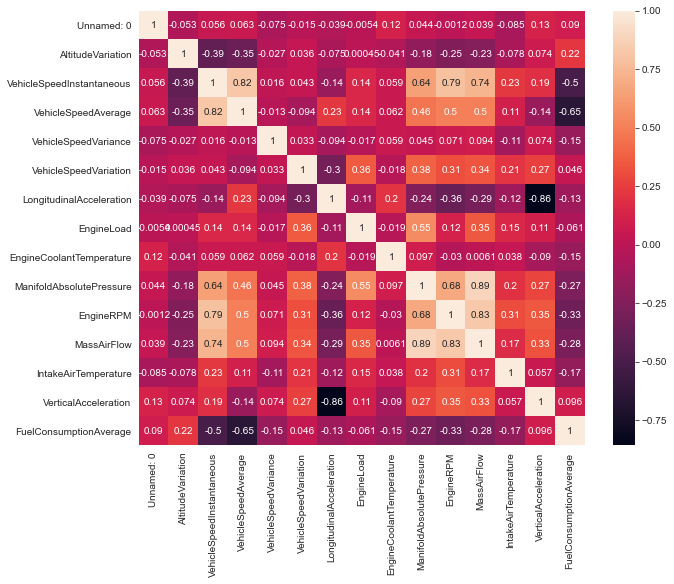

In [13]:
corr_heatmap(df1)

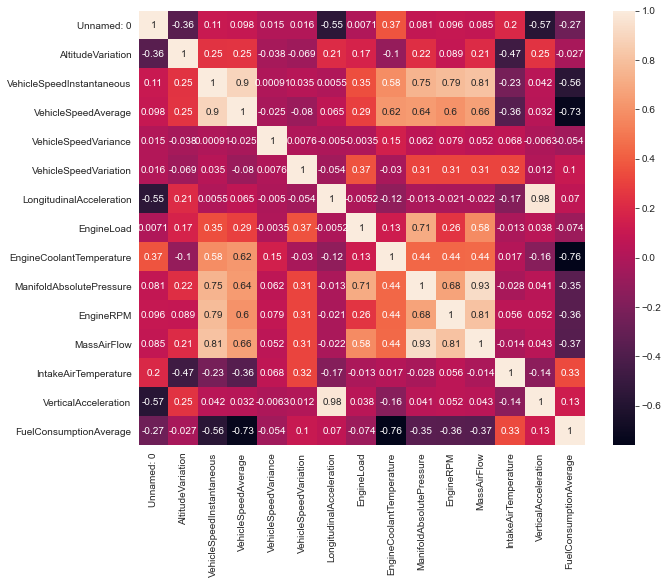

In [14]:
corr_heatmap(df2)

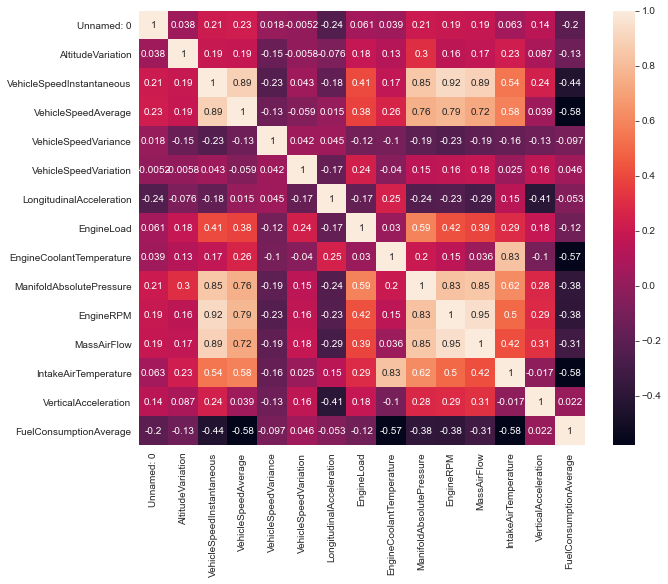

In [15]:
corr_heatmap(df3)

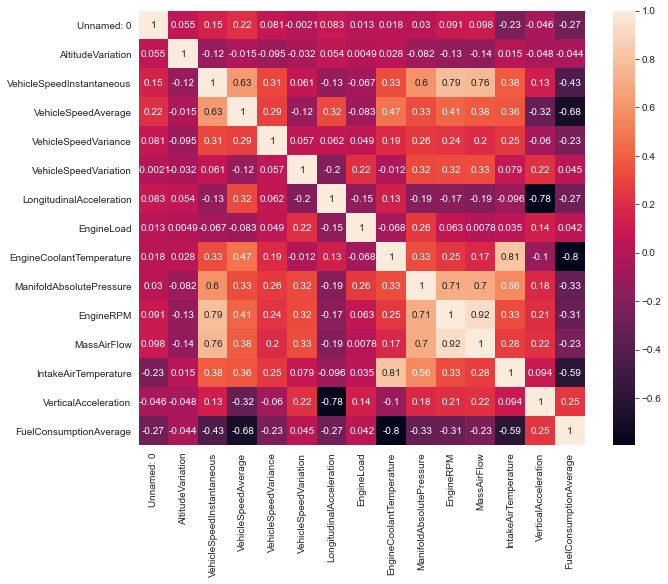

In [16]:
corr_heatmap(df4)

Some initial observations:

- While there are some patterns across datasets, there is also a lot of variation between them, and a very positive correlation in one dataset may be insignificant in another or it may be a strong negative correlation in a different dataset.


- Unsurprisingly, there is a very strong relation between `VehicleSpeedInstantaneous` and `VehicleSpeedAverage` - although this relationship is not as strong for the peugeot_02 dataset. 


- `ManifoldAbsolutePressure`, `EngineRPM` and `MassAirFlow` are strongly correlated with each other and with `VehicleSpeedInstantaneous` and `VehicleSpeedAverage` in all datasets.


- `FuelConsumptionAverage` is negatively correlated with `VehicleSpeedAverage` in all datasets,  and it also has a significant negative correlation with `EngineCoolantTemperature` and `IntakeAirTemperature` in the Peugeot datasets. 


- There is a strong negative correlation between `LongitudinalAcceleration` and `VerticalAcceleration` in opel_01 and peugeot_02, however they are extremely positively correlated in the opel_02 dataset.

#### Distribution of numerical variables
Now let's have a look at the distribution of the numerical variables in each dataset.

array([[<AxesSubplot:title={'center':'Unnamed: 0'}>,
        <AxesSubplot:title={'center':'AltitudeVariation'}>,
        <AxesSubplot:title={'center':'VehicleSpeedInstantaneous'}>,
        <AxesSubplot:title={'center':'VehicleSpeedAverage'}>],
       [<AxesSubplot:title={'center':'VehicleSpeedVariance'}>,
        <AxesSubplot:title={'center':'VehicleSpeedVariation'}>,
        <AxesSubplot:title={'center':'LongitudinalAcceleration'}>,
        <AxesSubplot:title={'center':'EngineLoad'}>],
       [<AxesSubplot:title={'center':'EngineCoolantTemperature'}>,
        <AxesSubplot:title={'center':'ManifoldAbsolutePressure'}>,
        <AxesSubplot:title={'center':'EngineRPM'}>,
        <AxesSubplot:title={'center':'MassAirFlow'}>],
       [<AxesSubplot:title={'center':'IntakeAirTemperature'}>,
        <AxesSubplot:title={'center':'VerticalAcceleration'}>,
        <AxesSubplot:title={'center':'FuelConsumptionAverage'}>,
        <AxesSubplot:>]], dtype=object)

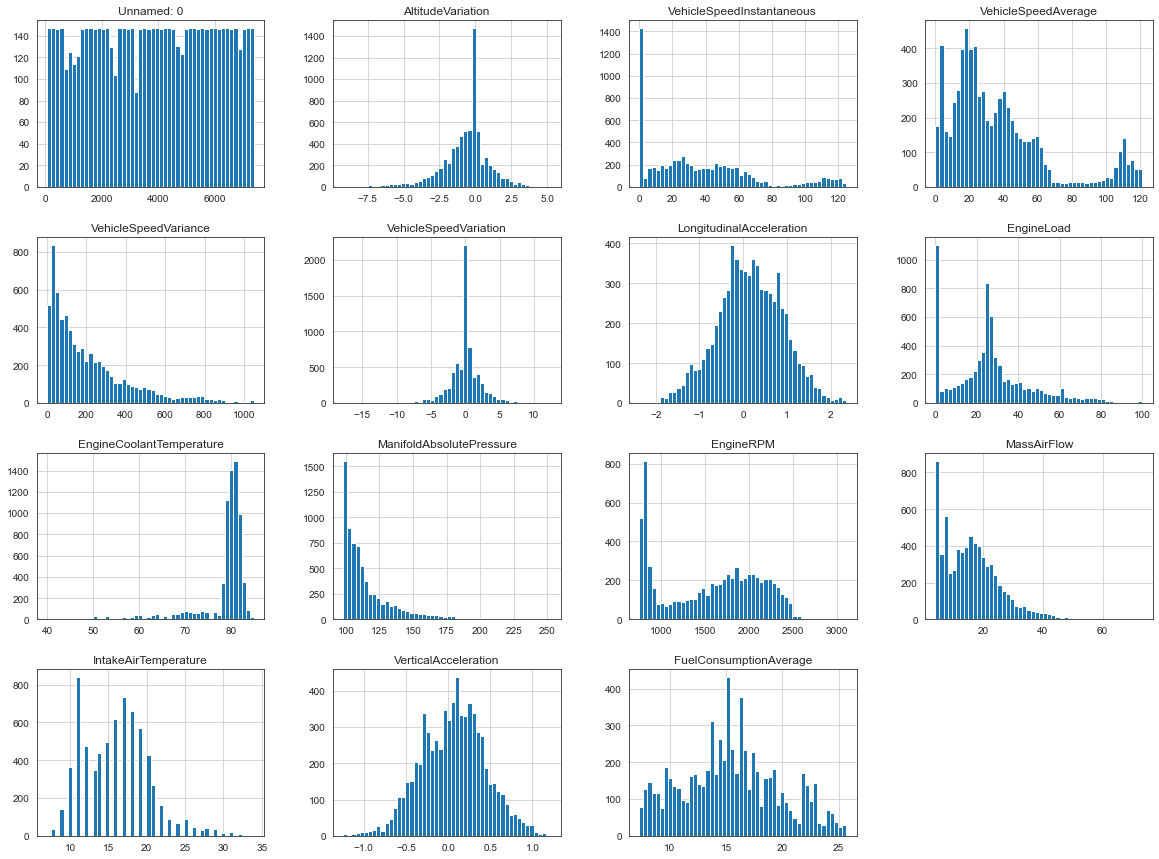

In [17]:
df1.hist(bins=50, figsize=(20,15))

array([[<AxesSubplot:title={'center':'Unnamed: 0'}>,
        <AxesSubplot:title={'center':'AltitudeVariation'}>,
        <AxesSubplot:title={'center':'VehicleSpeedInstantaneous'}>,
        <AxesSubplot:title={'center':'VehicleSpeedAverage'}>],
       [<AxesSubplot:title={'center':'VehicleSpeedVariance'}>,
        <AxesSubplot:title={'center':'VehicleSpeedVariation'}>,
        <AxesSubplot:title={'center':'LongitudinalAcceleration'}>,
        <AxesSubplot:title={'center':'EngineLoad'}>],
       [<AxesSubplot:title={'center':'EngineCoolantTemperature'}>,
        <AxesSubplot:title={'center':'ManifoldAbsolutePressure'}>,
        <AxesSubplot:title={'center':'EngineRPM'}>,
        <AxesSubplot:title={'center':'MassAirFlow'}>],
       [<AxesSubplot:title={'center':'IntakeAirTemperature'}>,
        <AxesSubplot:title={'center':'VerticalAcceleration'}>,
        <AxesSubplot:title={'center':'FuelConsumptionAverage'}>,
        <AxesSubplot:>]], dtype=object)

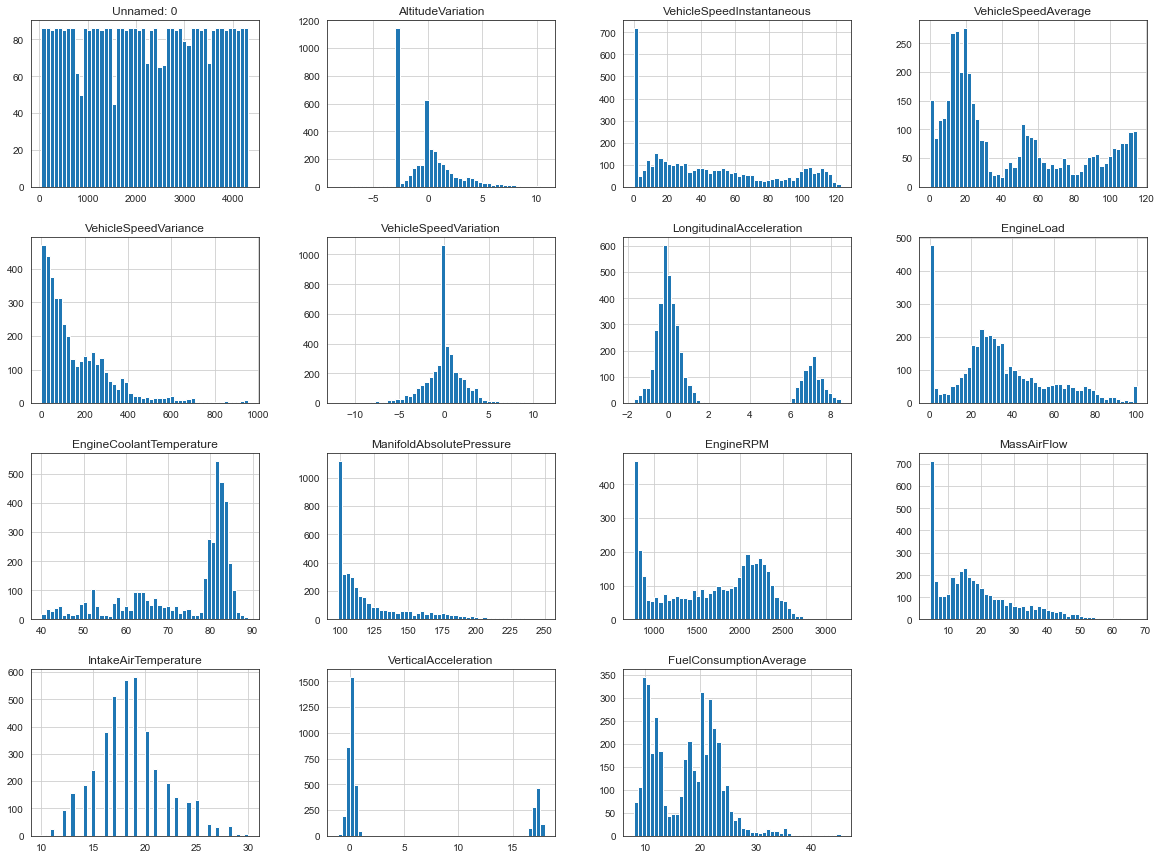

In [18]:
df2.hist(bins=50, figsize=(20,15))

array([[<AxesSubplot:title={'center':'Unnamed: 0'}>,
        <AxesSubplot:title={'center':'AltitudeVariation'}>,
        <AxesSubplot:title={'center':'VehicleSpeedInstantaneous'}>,
        <AxesSubplot:title={'center':'VehicleSpeedAverage'}>],
       [<AxesSubplot:title={'center':'VehicleSpeedVariance'}>,
        <AxesSubplot:title={'center':'VehicleSpeedVariation'}>,
        <AxesSubplot:title={'center':'LongitudinalAcceleration'}>,
        <AxesSubplot:title={'center':'EngineLoad'}>],
       [<AxesSubplot:title={'center':'EngineCoolantTemperature'}>,
        <AxesSubplot:title={'center':'ManifoldAbsolutePressure'}>,
        <AxesSubplot:title={'center':'EngineRPM'}>,
        <AxesSubplot:title={'center':'MassAirFlow'}>],
       [<AxesSubplot:title={'center':'IntakeAirTemperature'}>,
        <AxesSubplot:title={'center':'VerticalAcceleration'}>,
        <AxesSubplot:title={'center':'FuelConsumptionAverage'}>,
        <AxesSubplot:>]], dtype=object)

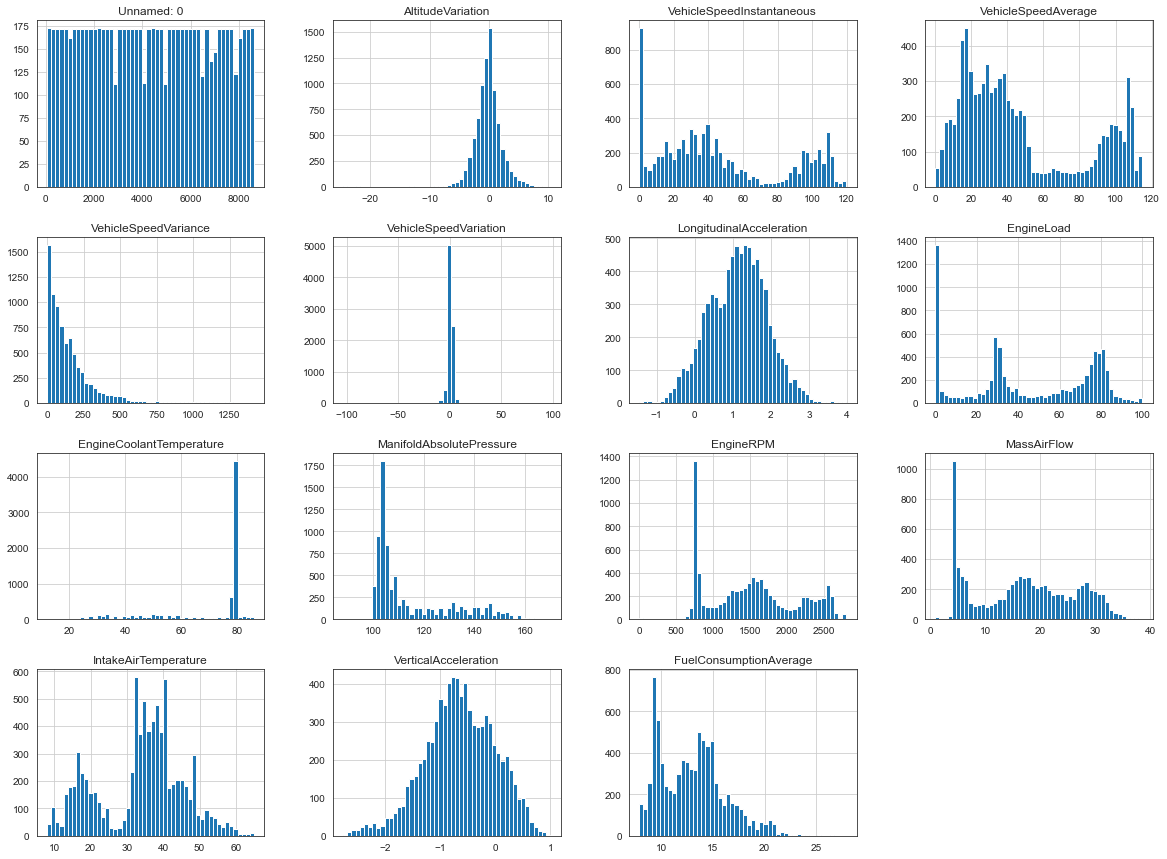

In [19]:
df3.hist(bins=50, figsize=(20,15))

array([[<AxesSubplot:title={'center':'Unnamed: 0'}>,
        <AxesSubplot:title={'center':'AltitudeVariation'}>,
        <AxesSubplot:title={'center':'VehicleSpeedInstantaneous'}>,
        <AxesSubplot:title={'center':'VehicleSpeedAverage'}>],
       [<AxesSubplot:title={'center':'VehicleSpeedVariance'}>,
        <AxesSubplot:title={'center':'VehicleSpeedVariation'}>,
        <AxesSubplot:title={'center':'LongitudinalAcceleration'}>,
        <AxesSubplot:title={'center':'EngineLoad'}>],
       [<AxesSubplot:title={'center':'EngineCoolantTemperature'}>,
        <AxesSubplot:title={'center':'ManifoldAbsolutePressure'}>,
        <AxesSubplot:title={'center':'EngineRPM'}>,
        <AxesSubplot:title={'center':'MassAirFlow'}>],
       [<AxesSubplot:title={'center':'IntakeAirTemperature'}>,
        <AxesSubplot:title={'center':'VerticalAcceleration'}>,
        <AxesSubplot:title={'center':'FuelConsumptionAverage'}>,
        <AxesSubplot:>]], dtype=object)

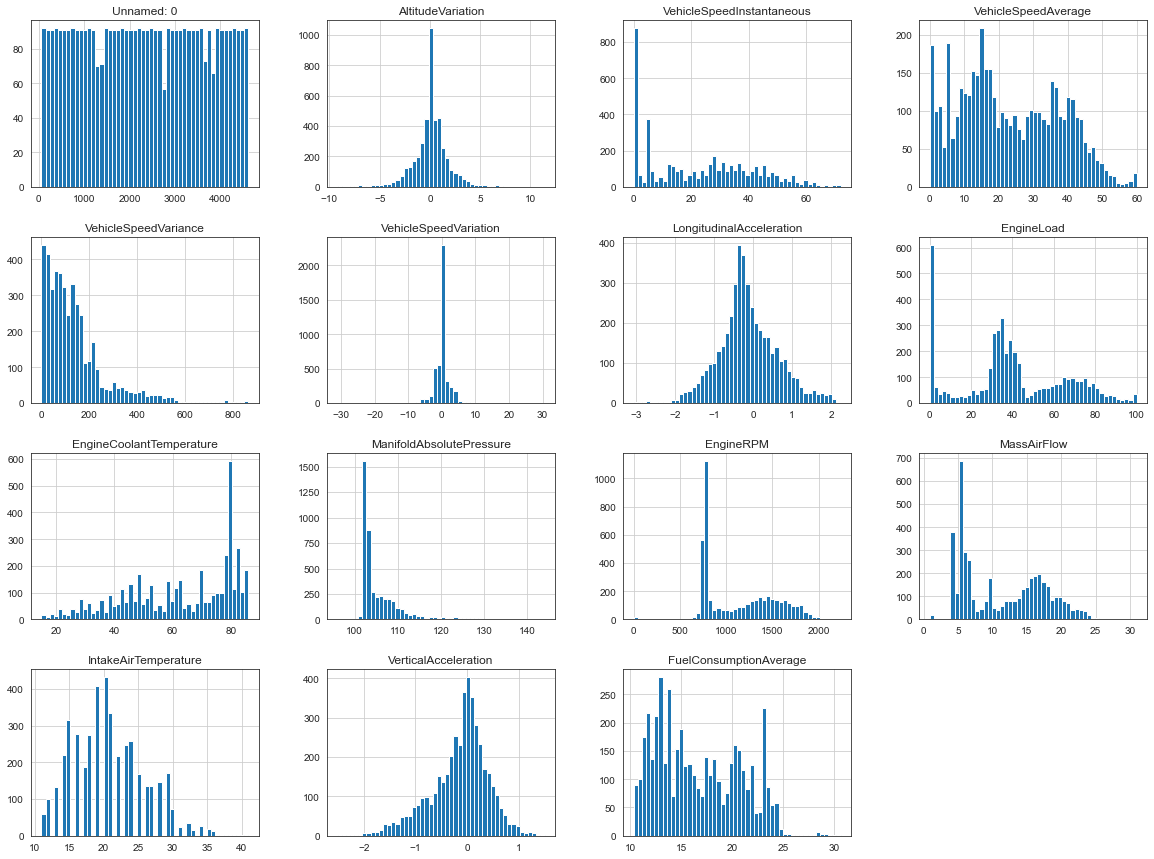

In [20]:
df4.hist(bins=50, figsize=(20,15))

For each dataset, the graphs for `VehicleSpeedInstantaneous`, `VehicleSpeedVariance`, `ManifoldAbsolutePressure`, `EngineRPM` and `MassAirFlow` are really right-skewed, while `EngineCoolantTemperature` has a long left tail in each of the datasets. We may need to do some kind of transformations on these variables to try create more normal distributions.

We can also see there is a clear difference in the shape of the distribution for `VerticalAcceleration` and `LongitudinalAcceleration` between the opel_02 dataset and the others. Let's take a closer look.

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-lev

[0.0, 1.4, 0.0, 1.4, 0.0, 1.4, 0.0, 1.4]

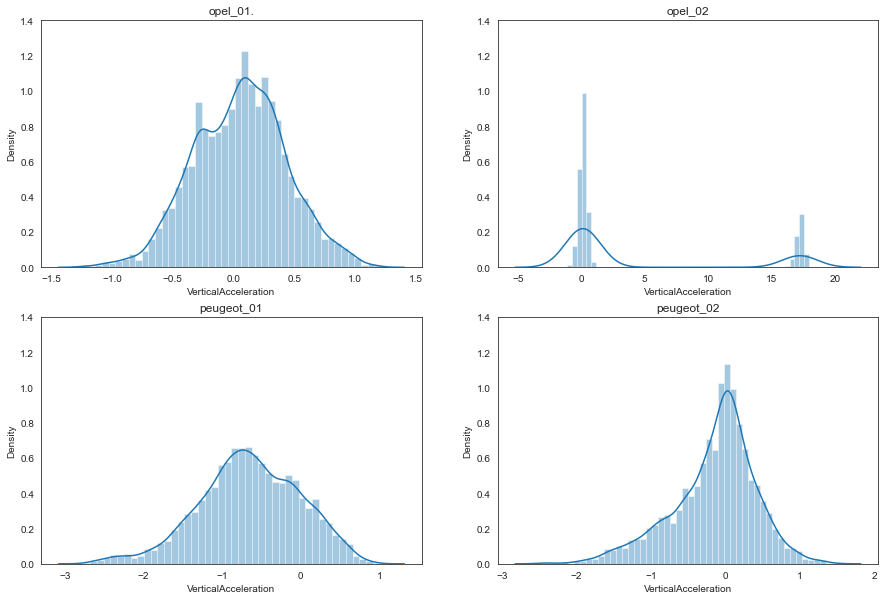

In [21]:
figure, axis = plt.subplots(2, 2, figsize=(15,10))

column = 'VerticalAcceleration' 

sns.distplot(df1[column], ax=axis[0, 0])
axis[0, 0].set_title(df1.dataframeName)

sns.distplot(df2[column], ax=axis[0, 1])
axis[0, 1].set_title(df2.dataframeName)
  
sns.distplot(df3[column], ax=axis[1, 0])
axis[1, 0].set_title(df3.dataframeName)
  
sns.distplot(df4[column], ax=axis[1, 1])
axis[1, 1].set_title(df4.dataframeName)

plt.setp(axis, ylim=(0,1.4))

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-lev

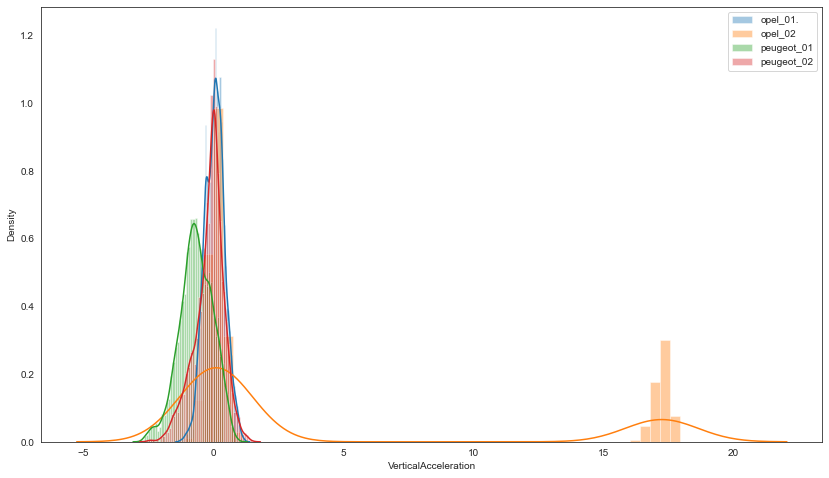

In [22]:
column = 'VerticalAcceleration'

plt.figure(figsize=(14,8))

for df in df_list:
    sns.distplot(df[column], label=df.dataframeName)

plt.legend()

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\ProgramData\Anacond

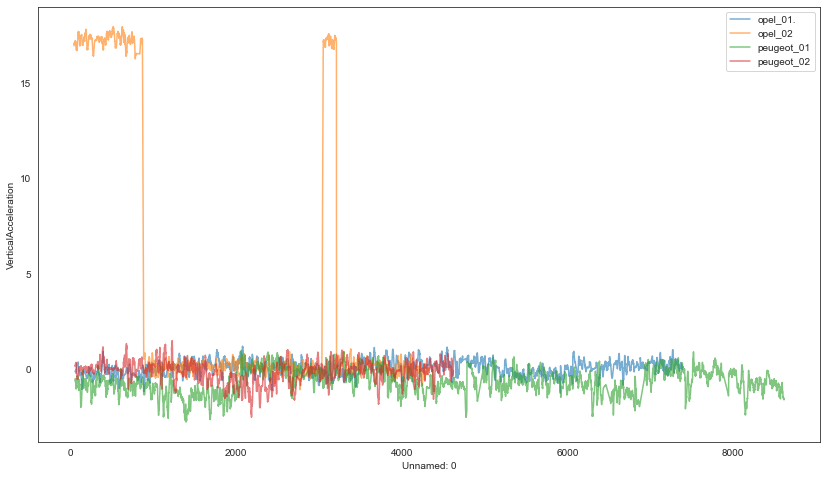

In [23]:
column = 'VerticalAcceleration'

plt.figure(figsize=(14,8))

for df in df_list:
    sns.lineplot(df['Unnamed: 0'], df[column], label=df.dataframeName, alpha=0.6)


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-lev

[0.0, 0.9, 0.0, 0.9, 0.0, 0.9, 0.0, 0.9]

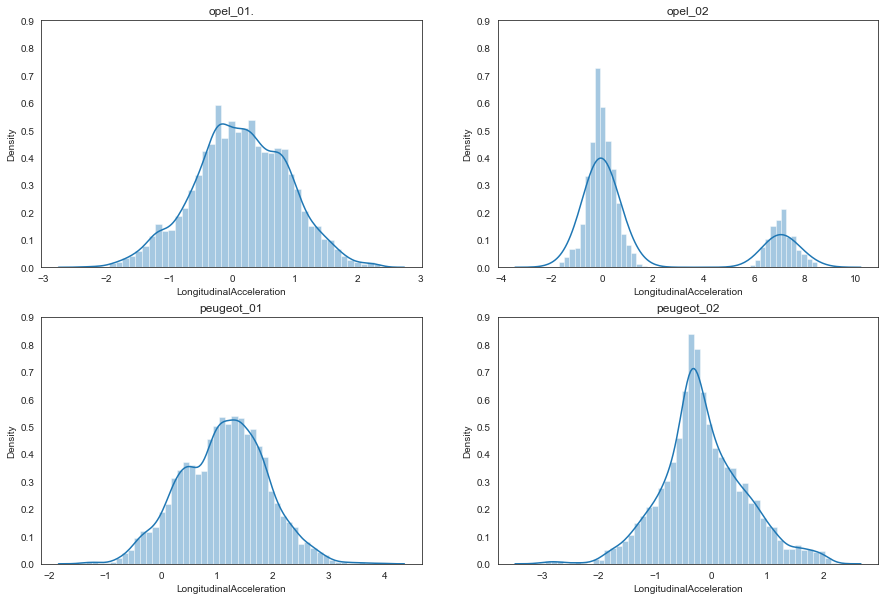

In [24]:
figure, axis = plt.subplots(2, 2, figsize=(15,10))

column = 'LongitudinalAcceleration' 

sns.distplot(df1[column], ax=axis[0, 0])
axis[0, 0].set_title(df1.dataframeName)
  
sns.distplot(df2[column], ax=axis[0, 1])
axis[0, 1].set_title(df2.dataframeName)
  
sns.distplot(df3[column], ax=axis[1, 0])
axis[1, 0].set_title(df3.dataframeName)
  
sns.distplot(df4[column], ax=axis[1, 1])
axis[1, 1].set_title(df4.dataframeName)

plt.setp(axis, ylim=(0,0.9))

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-lev

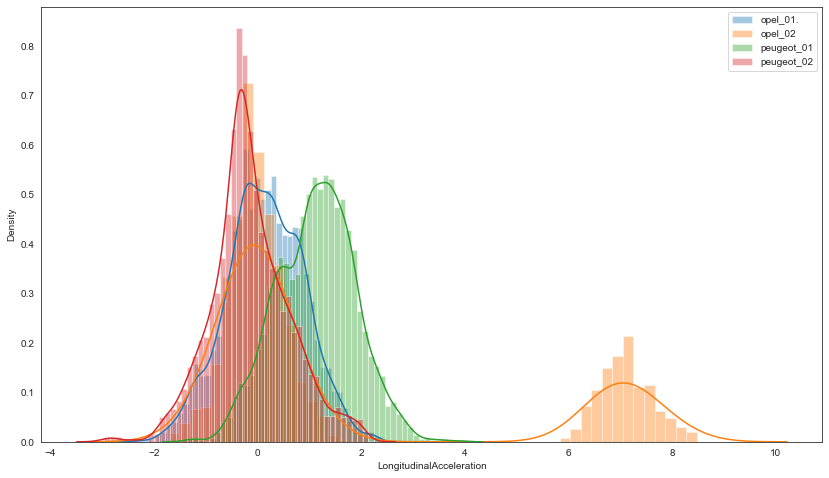

In [25]:
plt.figure(figsize=(14,8))

for df in df_list:
    sns.distplot(df[column], label=df.dataframeName)

plt.legend()

In [26]:
df2.describe()

Unnamed: 0  AltitudeVariation  VehicleSpeedInstantaneous  \
count  4092.000000        4092.000000                4092.000000   
mean   2198.175953          -0.139590                  43.482246   
std    1248.536624           2.484872                  37.543881   
min      44.000000          -8.299988                   0.000000   
25%    1125.750000          -2.800003                  11.259000   
50%    2188.500000           0.000000                  34.452538   
75%    3285.250000           1.024994                  70.312449   
max    4327.000000          10.700012                 122.723091   

       VehicleSpeedAverage  VehicleSpeedVariance  VehicleSpeedVariation  \
count          4092.000000           4092.000000            4092.000000   
mean             43.419217            162.980180              -0.011556   
std              35.323457            162.805408               2.227681   
min               0.000000              0.000000             -11.934539   
25%              14.868447             42.682230              -0.900719   
50%              26.422996            106.038210               0.000000   
75%              70.051620            240.313896               0.900722   
max             114.706688            956.695096              11.259000   

       LongitudinalAcceleration   EngineLoad  EngineCoolantTemperature  \
count               4092.000000  4092.000000               4092.000000   
mean                   1.603635    34.509613                 73.378299   
std                    3.057510    23.559170                 12.875391   
min                   -1.710800     0.000000                 40.000000   
25%                   -0.254950    20.000000                 64.000000   
50%                    0.125000    30.588236                 80.000000   
75%                    1.060000    47.843140                 83.000000   
max                    8.477800   100.000000                 89.000000   

       ManifoldAbsolutePressure    EngineRPM  MassAirFlow  \
count               4092.000000  4092.000000  4092.000000   
mean                 123.764907  1656.040811    18.608326   
std                   30.908416   575.566227    12.334384   
min                   98.000000   760.000000     4.270000   
25%                  101.000000  1087.000000     8.445000   
50%                  110.000000  1762.500000    15.820000   
75%                  136.000000  2156.000000    25.330000   
max                  250.000000  3167.000000    67.309998   

       IntakeAirTemperature  VerticalAcceleration  FuelConsumptionAverage  
count           4092.000000           4092.000000             4092.000000  
mean              18.521261              4.061078               17.400087  
std                3.408300              7.221253                5.970610  
min               10.000000             -1.140000                7.929113  
25%               16.000000             -0.007800               11.634232  
50%               18.000000              0.223000               18.079138  
75%               20.000000              0.716000               21.760530  
max               30.000000             17.944800               45.336861

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\ProgramData\Anacond

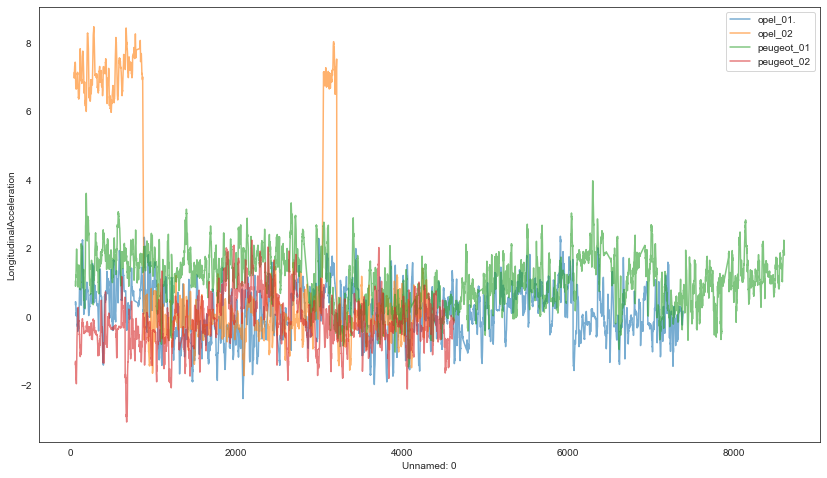

In [27]:
plt.figure(figsize=(14,8))

for df in df_list:
    sns.lineplot(df['Unnamed: 0'], df[column], label=df.dataframeName, alpha=0.6)


We can see that there are two distinct peaks for both variables at the same time in the opel_02 journey (could be caused by the smartphone accelerometer malfunctioning at these times?) The higher values for each of these variables in the opel_02 dataset could cause the overall dataset to have some outliers, so we should keep an eye on these variables later. 

#### Comparing the distribution of categorical variables in each dataset.

In [28]:
def get_class_proportions(df, category):
   print("\n", df.dataframeName, ":")
   for i in range(len(list(df[category].unique()))):
        print(df[category].unique()[i])
        print(df[category].value_counts()[i], "-", round((df[category].value_counts()[i])/df.shape[0]*100, 2),"%")       

In [29]:
category = 'drivingStyle'

for df in df_list:
    get_class_proportions(df, category)


 opel_01. :
EvenPaceStyle
5751 - 81.71 %
AggressiveStyle
1287 - 18.29 %

 opel_02 :
EvenPaceStyle
3290 - 80.4 %
AggressiveStyle
802 - 19.6 %

 peugeot_01 :
EvenPaceStyle
7716 - 94.11 %
AggressiveStyle
483 - 5.89 %

 peugeot_02 :
EvenPaceStyle
4259 - 95.79 %
AggressiveStyle
187 - 4.21 %


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\si

Text(0.5, 1.0, 'peugeot_02')

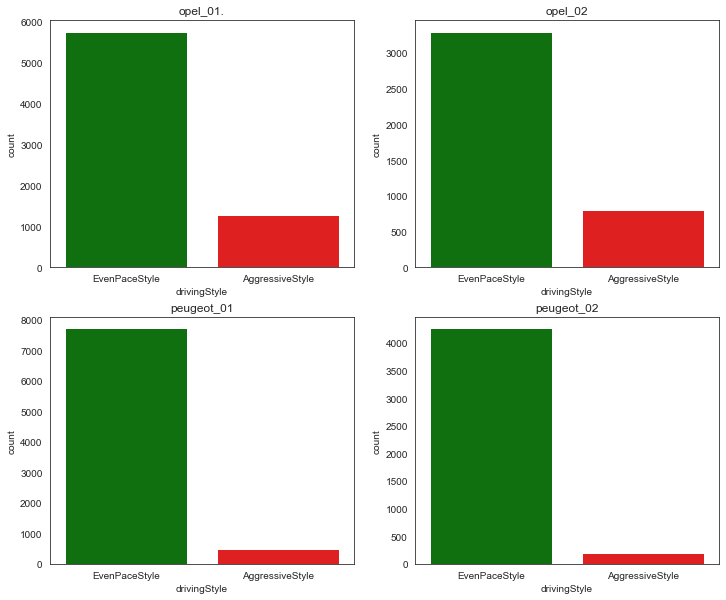

In [30]:
figure, axis = plt.subplots(2, 2, figsize=(12,10))

palette_dict = dict(EvenPaceStyle="g", AggressiveStyle="r")

sns.countplot(df1[category], palette=palette_dict, ax=axis[0, 0])
axis[0, 0].set_title(df1.dataframeName)
  
sns.countplot(df2[category], palette=palette_dict, ax=axis[0, 1])
axis[0, 1].set_title(df2.dataframeName)
  
sns.countplot(df3[category], palette=palette_dict, ax=axis[1, 0])
axis[1, 0].set_title(df3.dataframeName)
  
sns.countplot(df4[category], palette=palette_dict, ax=axis[1, 1])
axis[1, 1].set_title(df4.dataframeName)

In general, the distribution of driving styles in each dataset seems to be quite similar, although the Peugeot datasets have about 15% less aggressive style driving compared to the Opel datasets.

Now let's look at the `roadSurface`.

In [31]:
category = 'roadSurface'

for df in df_list:
    get_class_proportions(df, category)


 opel_01. :
SmoothCondition
6873 - 97.66 %
UnevenCondition
165 - 2.34 %

 opel_02 :
SmoothCondition
3812 - 93.16 %
UnevenCondition
280 - 6.84 %

 peugeot_01 :
SmoothCondition
3274 - 39.93 %
FullOfHolesCondition
3042 - 37.1 %
UnevenCondition
1883 - 22.97 %

 peugeot_02 :
UnevenCondition
2802 - 63.02 %
FullOfHolesCondition
1366 - 30.72 %
SmoothCondition
278 - 6.25 %


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\si

Text(0.5, 1.0, 'peugeot_02')

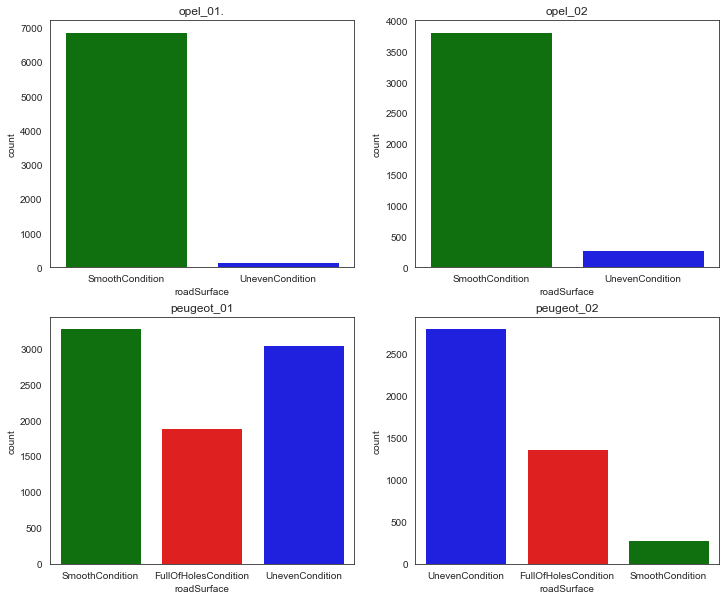

In [32]:
figure, axis = plt.subplots(2, 2, figsize=(12,10))

palette_dict = dict(SmoothCondition="g", UnevenCondition="b", FullOfHolesCondition="r")

sns.countplot(df1[category], palette=palette_dict, ax=axis[0, 0])
axis[0, 0].set_title(df1.dataframeName)
  
sns.countplot(df2[category], palette=palette_dict, ax=axis[0, 1])
axis[0, 1].set_title(df2.dataframeName)
  
sns.countplot(df3[category], palette=palette_dict, ax=axis[1, 0])
axis[1, 0].set_title(df3.dataframeName)
  
sns.countplot(df4[category], palette=palette_dict, ax=axis[1, 1])
axis[1, 1].set_title(df4.dataframeName)

From the statistics and charts above we see there is a big inbalance between the datasets for this target class. While the Opel trips were driven on mostly smooth roads, the two Peugeot trips were on considerably worst road surfaces, especially the second Peugeot trip where only 6% on the roads were in a smooth condition. We would need to accomodate for this inbalance when splitting the final dataset into train and test sets if we choose this as our target class for the model.

The last category class we will compare is `traffic`.

In [33]:
traffic_conditions = {'LowCongestionCondition':'Low', 'NormalCongestionCondition':'Medium',
                      'HighCongestionCondition':'High'}

for df in df_list:
    df.traffic = df.traffic.map(traffic_conditions)

In [34]:
category = 'traffic'

for df in df_list:
    get_class_proportions(df, category)


 opel_01. :
Low
6461 - 91.8 %
Medium
449 - 6.38 %
High
128 - 1.82 %

 opel_02 :
Low
3591 - 87.76 %
High
405 - 9.9 %
Medium
96 - 2.35 %

 peugeot_01 :
Low
6844 - 83.47 %
Medium
696 - 8.49 %
High
659 - 8.04 %

 peugeot_02 :
Medium
1813 - 40.78 %
High
1765 - 39.7 %
Low
868 - 19.52 %


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\si

Text(0.5, 1.0, 'peugeot_02')

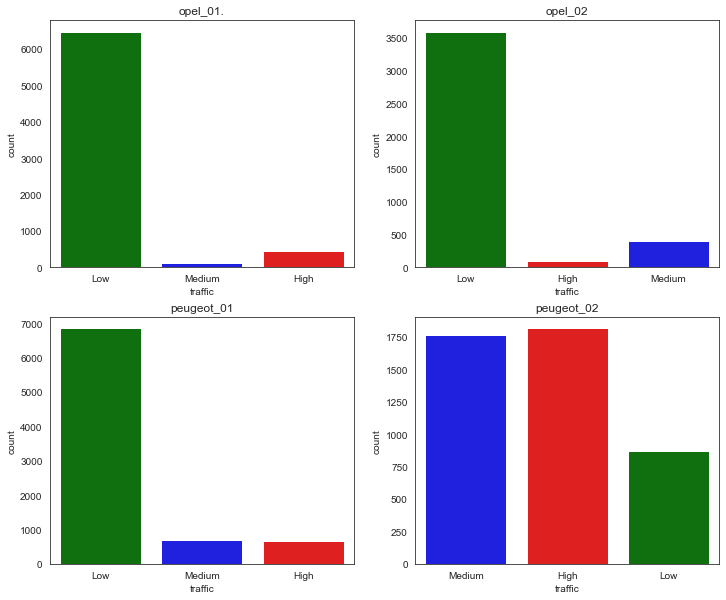

In [35]:
figure, axis = plt.subplots(2, 2, figsize=(12,10))

palette_dict = dict(Low="g", Medium="b", High="r")

sns.countplot(df1[category], palette=palette_dict, ax=axis[0, 0])
axis[0, 0].set_title(df1.dataframeName)
  
sns.countplot(df2[category], palette=palette_dict, ax=axis[0, 1])
axis[0, 1].set_title(df2.dataframeName)
  
sns.countplot(df3[category], palette=palette_dict, ax=axis[1, 0])
axis[1, 0].set_title(df3.dataframeName)
  
sns.countplot(df4[category], palette=palette_dict, ax=axis[1, 1])
axis[1, 1].set_title(df4.dataframeName)

While the traffic congestion conditions for the first three datasets are quite similar, there was clearly much more congestion during the last trip. Let's visualize the vehicle speed during the different trips to see if if the high traffic for trip 4 is noticable.

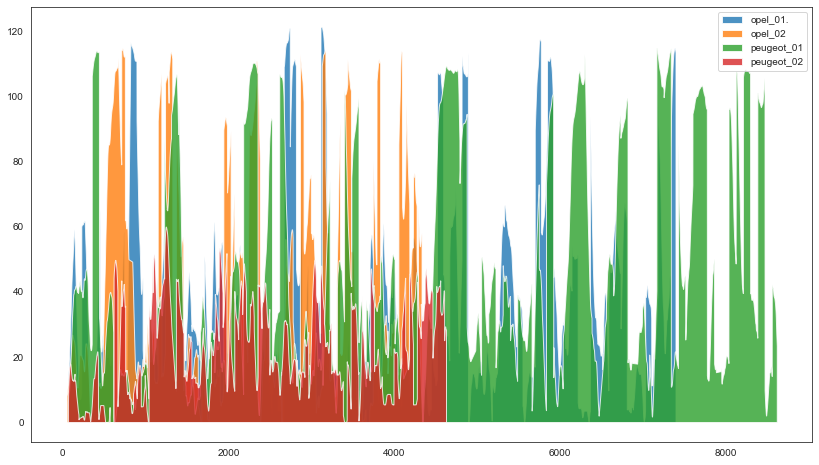

In [36]:
plt.figure(figsize=(14,8))

for df in df_list:
    plt.fill_between(df['Unnamed: 0'], df['VehicleSpeedAverage'], label=df.dataframeName, alpha=0.8)

plt.legend()

Text(0.5, 1.0, 'peugeot_02')

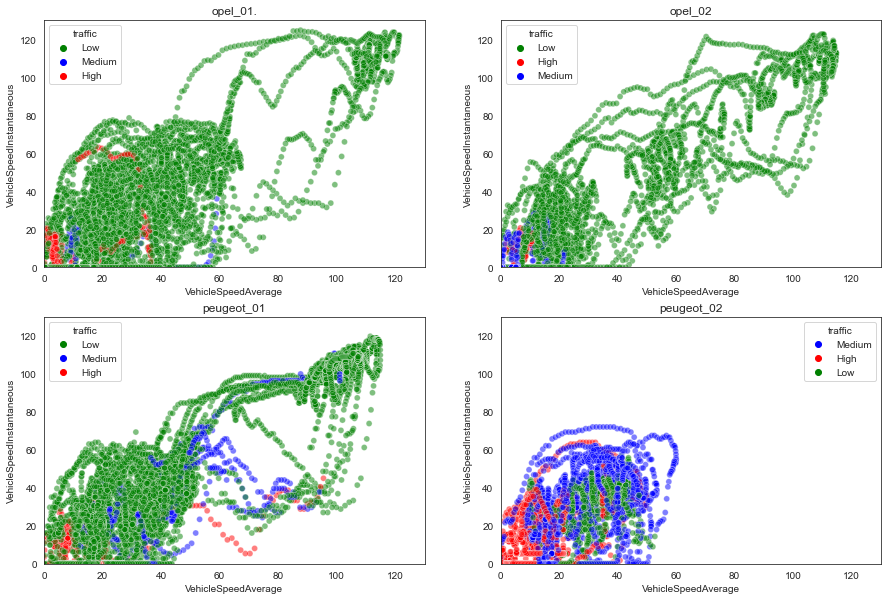

In [37]:
figure, axis = plt.subplots(2, 2, figsize=(15,10))

y_column = 'VehicleSpeedInstantaneous'
x_column = 'VehicleSpeedAverage'

plt.setp(axis, ylim=(0,130), xlim=(0,130))

sns.scatterplot(x=x_column, y=y_column, data=df1, alpha=0.5, hue='traffic', 
                palette=palette_dict, ax=axis[0,0])
axis[0, 0].set_title(df1.dataframeName)

sns.scatterplot(x=x_column, y=y_column, data=df2, alpha=0.5, hue='traffic', 
                palette=palette_dict, ax=axis[0,1])
axis[0, 1].set_title(df2.dataframeName)

sns.scatterplot(x=x_column, y=y_column, data=df3, alpha=0.5, hue='traffic', 
                palette=palette_dict, ax=axis[1,0])
axis[1, 0].set_title(df3.dataframeName)

sns.scatterplot(x=x_column, y=y_column, data=df4, alpha=0.5, hue='traffic', 
               palette=palette_dict, ax=axis[1,1])
axis[1, 1].set_title(df4.dataframeName)


From these charts we can see that when there is mainly low traffic congestion the vehicle can go at greater speeds, but during trip 4 there was too much medium to high traffic congestion to allow the vehicle to reach higher speeds.  

So we can make an assumption that once the speed goes over a certain threshold, there is a higher probability that there is low traffic.

Let's see if it's the same for road surface, do higher speeds indicate that the road surface was probably in a better condition?

Text(0.5, 1.0, 'peugeot_02')

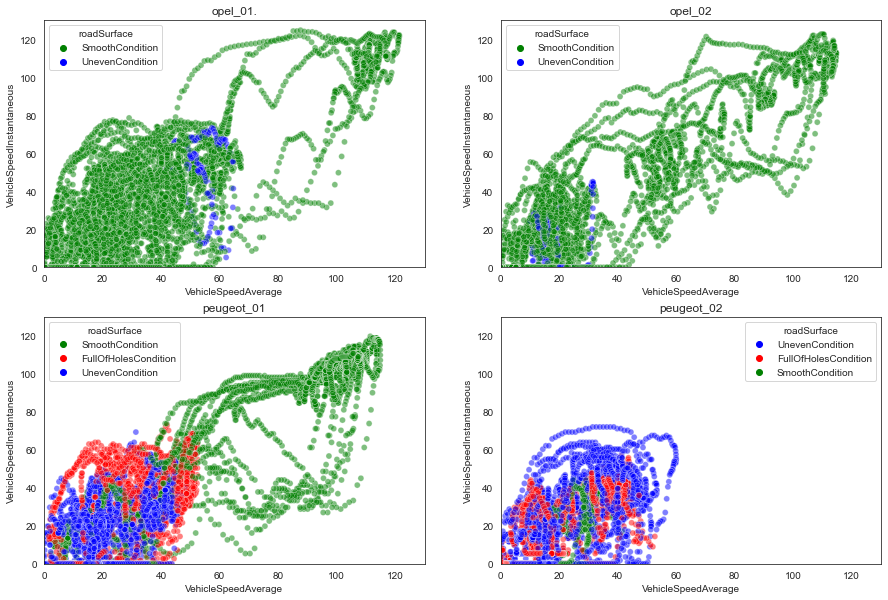

In [38]:
figure, axis = plt.subplots(2, 2, figsize=(15,10))

palette_dict = dict(SmoothCondition="g", UnevenCondition="b", FullOfHolesCondition="r")

y_column = 'VehicleSpeedInstantaneous'
x_column = 'VehicleSpeedAverage'

plt.setp(axis, ylim=(0,130), xlim=(0,130))

sns.scatterplot(x=x_column, y=y_column, data=df1, alpha=0.5, hue='roadSurface', 
                palette=palette_dict, ax=axis[0,0])
axis[0, 0].set_title(df1.dataframeName)

sns.scatterplot(x=x_column, y=y_column, data=df2, alpha=0.5, hue='roadSurface', 
                palette=palette_dict, ax=axis[0,1])
axis[0, 1].set_title(df2.dataframeName)

sns.scatterplot(x=x_column, y=y_column, data=df3, alpha=0.5, hue='roadSurface', 
                palette=palette_dict, ax=axis[1,0])
axis[1, 0].set_title(df3.dataframeName)

sns.scatterplot(x=x_column, y=y_column, data=df4, alpha=0.5, hue='roadSurface', 
               palette=palette_dict, ax=axis[1,1])
axis[1, 1].set_title(df4.dataframeName)


In the first 2 trips, high speeds seem to go hand-in-hand with smooth roads, but in the third trip (peugeot_01) there were slightly higher speeds when the road was full of holes compared to just an uneven condition, and for the fourth trip (peugeot_02) higher speeds were reached on both roads with uneven condition and roads full of holes, compared to smooth roads, so maybe speed isn't quite as reliable as a predictor for road surface condition as it is for traffic congestion. 

Now let's use one-hot encoding to turn the categories into numerical values and further explore how they are correlated to the other variables using correlation matrices and heatmaps.

In [40]:
df1_dummies = pd.get_dummies(df1)
df2_dummies = pd.get_dummies(df2)
df3_dummies = pd.get_dummies(df3)
df4_dummies = pd.get_dummies(df4)

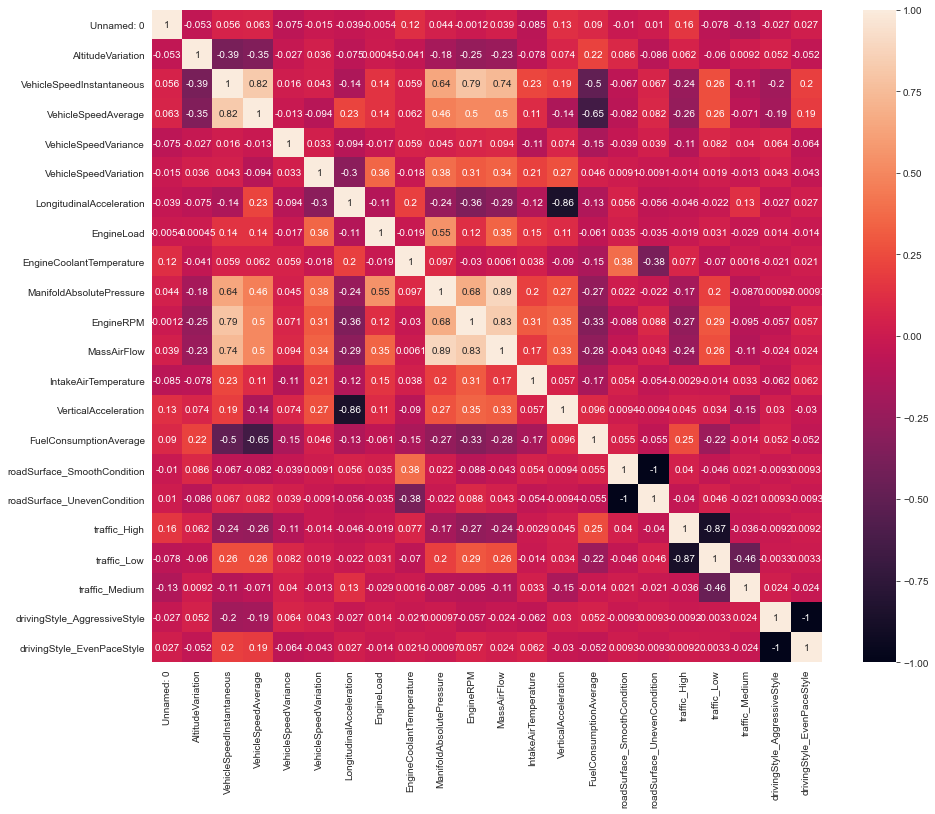

In [41]:
corr_heatmap(df1_dummies,15,12)

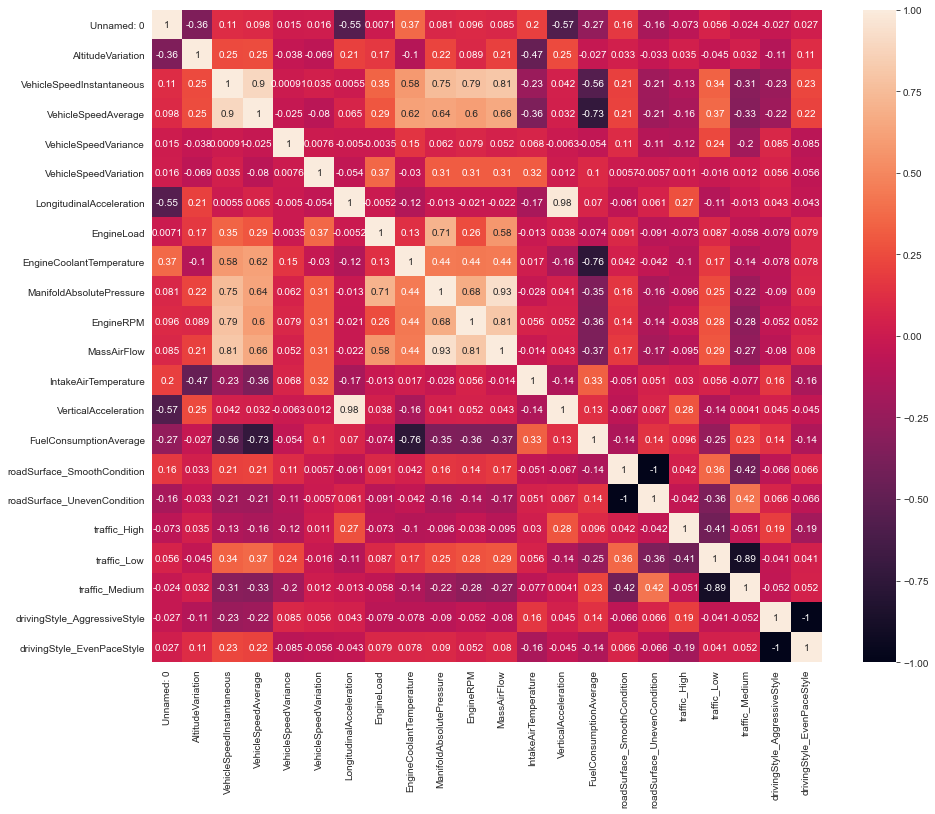

In [42]:
corr_heatmap(df2_dummies,15,12)

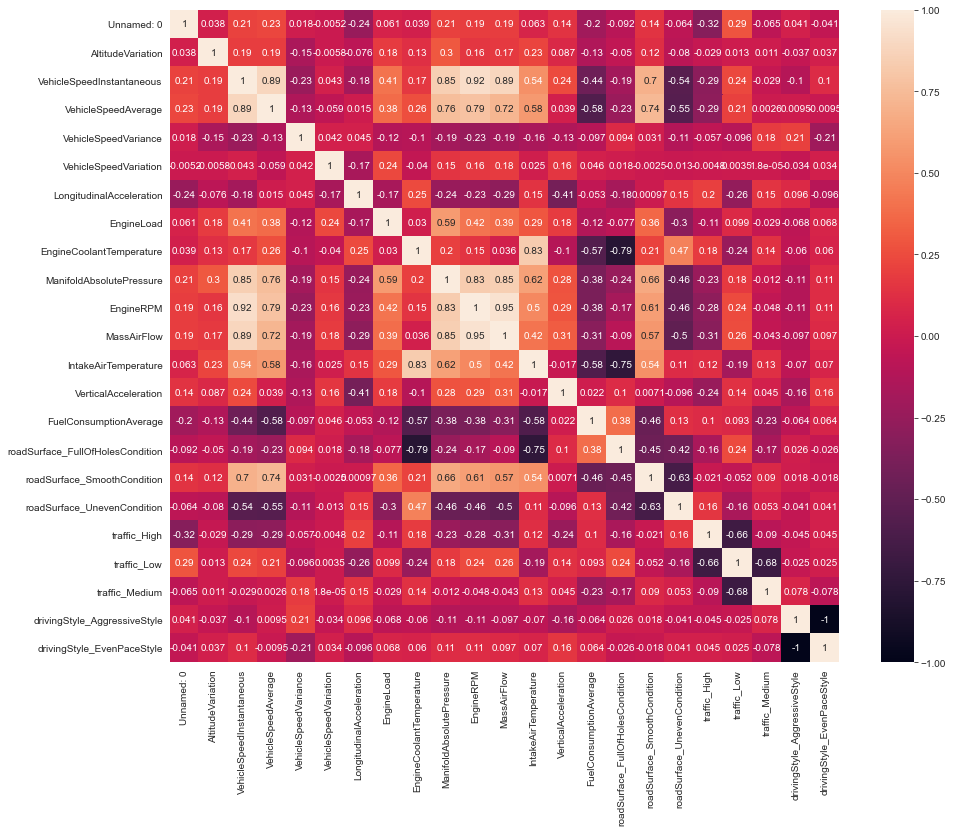

In [43]:
corr_heatmap(df3_dummies,15,12)

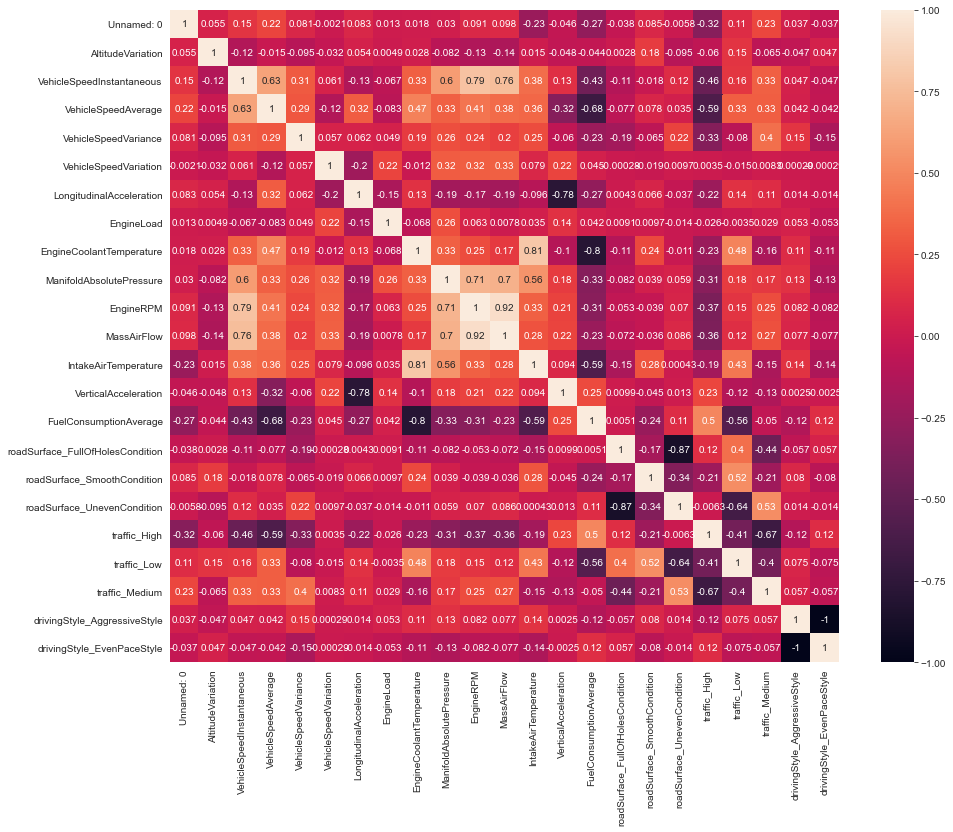

In [44]:
corr_heatmap(df4_dummies,15,12)

In [45]:
df_dummies = pd.DataFrame(columns=list(df1_dummies.columns))
df_dummies = pd.concat([df1_dummies, df2_dummies, df3_dummies, df4_dummies], axis=0)
print(df_dummies.shape)
df_dummies.head()

(23775, 23)


Unnamed: 0  AltitudeVariation  VehicleSpeedInstantaneous  \
0          59          -2.299988                  25.670519   
1          60          -2.099976                  24.094259   
2          61          -1.500000                  22.743179   
3          62           0.100037                  22.292820   
4          63           0.099976                  23.643900   

   VehicleSpeedAverage  VehicleSpeedVariance  VehicleSpeedVariation  \
0            13.223501            121.592690              -2.476980   
1            13.638919            120.422571              -1.576260   
2            14.031043            118.456769              -1.351080   
3            14.171073            117.571308              -0.450359   
4            14.328954            117.074149               1.351080   

   LongitudinalAcceleration  EngineLoad  EngineCoolantTemperature  \
0                    0.3555    4.705883                      68.0   
1                    0.4492   10.588236                      68.0   
2                    0.4258   27.450981                      68.0   
3                    0.4140   24.313726                      69.0   
4                    0.3945   20.000000                      69.0   

   ManifoldAbsolutePressure  ...  VerticalAcceleration  \
0                     106.0  ...               -0.1133   
1                     103.0  ...               -0.1289   
2                     103.0  ...               -0.1328   
3                     104.0  ...               -0.0859   
4                     104.0  ...               -0.0664   

   FuelConsumptionAverage  roadSurface_SmoothCondition  \
0               19.497335                            1   
1               19.515722                            1   
2               19.441765                            1   
3               19.388769                            1   
4               19.301638                            1   

   roadSurface_UnevenCondition  traffic_High  traffic_Low  traffic_Medium  \
0                            0             0            1               0   
1                            0             0            1               0   
2                            0             0            1               0   
3                            0             0            1               0   
4                            0             0            1               0   

   drivingStyle_AggressiveStyle  drivingStyle_EvenPaceStyle  \
0                             0                           1   
1                             0                           1   
2                             0                           1   
3                             0                           1   
4                             0                           1   

   roadSurface_FullOfHolesCondition  
0                               NaN  
1                               NaN  
2                               NaN  
3                               NaN  
4                               NaN  

[5 rows x 23 columns]

In [46]:
df_dummies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23775 entries, 0 to 4445
Data columns (total 23 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Unnamed: 0                        23775 non-null  int64  
 1   AltitudeVariation                 23775 non-null  float64
 2   VehicleSpeedInstantaneous         23766 non-null  float64
 3   VehicleSpeedAverage               23775 non-null  float64
 4   VehicleSpeedVariance              23775 non-null  float64
 5   VehicleSpeedVariation             23775 non-null  float64
 6   LongitudinalAcceleration          23775 non-null  float64
 7   EngineLoad                        23770 non-null  float64
 8   EngineCoolantTemperature          23770 non-null  float64
 9   ManifoldAbsolutePressure          23770 non-null  float64
 10  EngineRPM                         23770 non-null  float64
 11  MassAirFlow                       23770 non-null  float64
 12  Intak

In [47]:
df_dummies = df_dummies.fillna(0) # filling the empty rows for full of holes condition as that category was missing in two datasets
df_dummies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23775 entries, 0 to 4445
Data columns (total 23 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Unnamed: 0                        23775 non-null  int64  
 1   AltitudeVariation                 23775 non-null  float64
 2   VehicleSpeedInstantaneous         23775 non-null  float64
 3   VehicleSpeedAverage               23775 non-null  float64
 4   VehicleSpeedVariance              23775 non-null  float64
 5   VehicleSpeedVariation             23775 non-null  float64
 6   LongitudinalAcceleration          23775 non-null  float64
 7   EngineLoad                        23775 non-null  float64
 8   EngineCoolantTemperature          23775 non-null  float64
 9   ManifoldAbsolutePressure          23775 non-null  float64
 10  EngineRPM                         23775 non-null  float64
 11  MassAirFlow                       23775 non-null  float64
 12  Intak

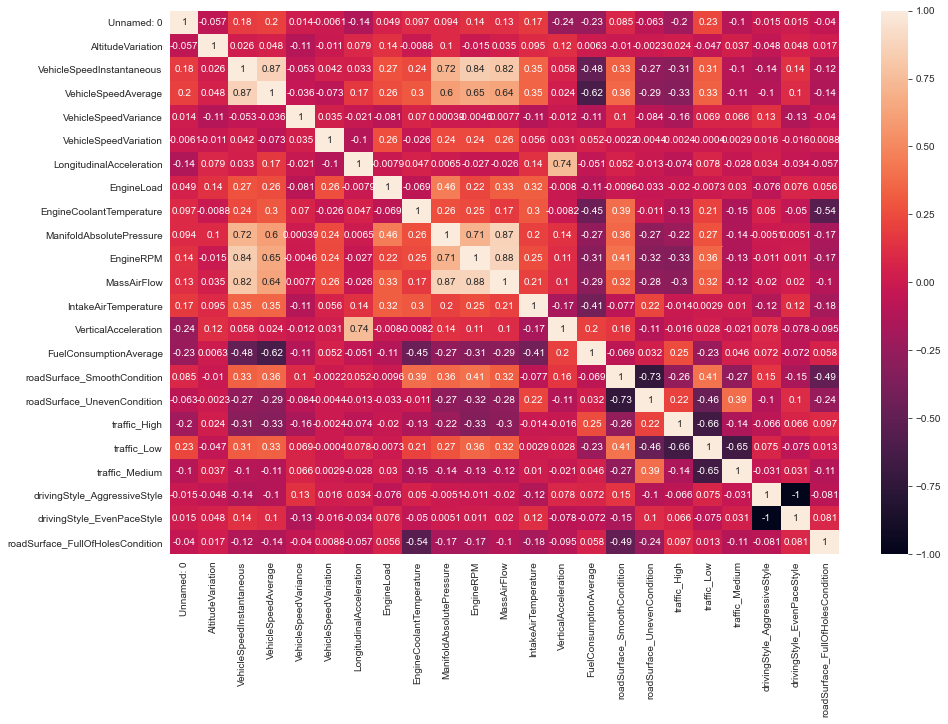

In [48]:
corr_heatmap(df_dummies, 15, 10) #heatmap for all the datasets combined

Comparing the correlation with roadSurface classes and the rest of the dataset.

In [49]:
corr_matrix = df_dummies.corr()

In [50]:
corr_matrix['roadSurface_SmoothCondition'].sort_values(ascending=False, key=abs)

roadSurface_SmoothCondition         1.000000
roadSurface_UnevenCondition        -0.732700
roadSurface_FullOfHolesCondition   -0.486075
traffic_Low                         0.406635
EngineRPM                           0.405308
EngineCoolantTemperature            0.386893
ManifoldAbsolutePressure            0.363047
VehicleSpeedAverage                 0.362164
VehicleSpeedInstantaneous           0.331442
MassAirFlow                         0.322034
traffic_Medium                     -0.268453
traffic_High                       -0.263392
VerticalAcceleration                0.163430
drivingStyle_AggressiveStyle        0.150004
drivingStyle_EvenPaceStyle         -0.150004
VehicleSpeedVariance                0.104172
Unnamed: 0                          0.084757
IntakeAirTemperature               -0.076922
FuelConsumptionAverage             -0.069356
LongitudinalAcceleration            0.051849
AltitudeVariation                  -0.009995
EngineLoad                         -0.009645
VehicleSpe

In [51]:
corr_matrix['roadSurface_UnevenCondition'].sort_values(ascending=False, key=abs)

roadSurface_UnevenCondition         1.000000
roadSurface_SmoothCondition        -0.732700
traffic_Low                        -0.461833
traffic_Medium                      0.387456
EngineRPM                          -0.315107
VehicleSpeedAverage                -0.294049
MassAirFlow                        -0.277078
ManifoldAbsolutePressure           -0.274877
VehicleSpeedInstantaneous          -0.271829
roadSurface_FullOfHolesCondition   -0.238599
IntakeAirTemperature                0.224771
traffic_High                        0.216853
VerticalAcceleration               -0.107318
drivingStyle_AggressiveStyle       -0.103855
drivingStyle_EvenPaceStyle          0.103855
VehicleSpeedVariance               -0.084312
Unnamed: 0                         -0.063293
EngineLoad                         -0.032652
FuelConsumptionAverage              0.031547
LongitudinalAcceleration           -0.012922
EngineCoolantTemperature           -0.011208
VehicleSpeedVariation              -0.004375
AltitudeVa

In [52]:
corr_matrix['roadSurface_FullOfHolesCondition'].sort_values(ascending=False, key=abs)

roadSurface_FullOfHolesCondition    1.000000
EngineCoolantTemperature           -0.537687
roadSurface_SmoothCondition        -0.486075
roadSurface_UnevenCondition        -0.238599
IntakeAirTemperature               -0.178871
EngineRPM                          -0.173719
ManifoldAbsolutePressure           -0.165075
VehicleSpeedAverage                -0.139195
VehicleSpeedInstantaneous          -0.123890
traffic_Medium                     -0.114473
MassAirFlow                        -0.103725
traffic_High                        0.097382
VerticalAcceleration               -0.095398
drivingStyle_AggressiveStyle       -0.080686
drivingStyle_EvenPaceStyle          0.080686
FuelConsumptionAverage              0.058457
LongitudinalAcceleration           -0.057393
EngineLoad                          0.055693
VehicleSpeedVariance               -0.040382
Unnamed: 0                         -0.039668
AltitudeVariation                   0.017164
traffic_Low                         0.012802
VehicleSpe

Comparing the correlation with traffic classes and the rest of the dataset.

In [53]:
corr_matrix['traffic_High'].sort_values(ascending=False, key=abs)

traffic_High                        1.000000
traffic_Low                        -0.655378
EngineRPM                          -0.334759
VehicleSpeedAverage                -0.325359
VehicleSpeedInstantaneous          -0.307442
MassAirFlow                        -0.298235
roadSurface_SmoothCondition        -0.263392
FuelConsumptionAverage              0.251340
ManifoldAbsolutePressure           -0.222664
roadSurface_UnevenCondition         0.216853
Unnamed: 0                         -0.202326
VehicleSpeedVariance               -0.155008
traffic_Medium                     -0.144706
EngineCoolantTemperature           -0.130572
roadSurface_FullOfHolesCondition    0.097382
LongitudinalAcceleration           -0.073743
drivingStyle_AggressiveStyle       -0.066326
drivingStyle_EvenPaceStyle          0.066326
AltitudeVariation                   0.024357
EngineLoad                         -0.020093
VerticalAcceleration               -0.016109
IntakeAirTemperature               -0.013768
VehicleSpe

In [54]:
corr_matrix['traffic_Medium'].sort_values(ascending=False, key=abs)

traffic_Medium                      1.000000
traffic_Low                        -0.652514
roadSurface_UnevenCondition         0.387456
roadSurface_SmoothCondition        -0.268453
EngineCoolantTemperature           -0.147419
traffic_High                       -0.144706
ManifoldAbsolutePressure           -0.135753
EngineRPM                          -0.134645
MassAirFlow                        -0.115996
roadSurface_FullOfHolesCondition   -0.114473
VehicleSpeedAverage                -0.107162
VehicleSpeedInstantaneous          -0.100988
Unnamed: 0                         -0.100546
VehicleSpeedVariance                0.065516
FuelConsumptionAverage              0.045888
AltitudeVariation                   0.037395
drivingStyle_AggressiveStyle       -0.031446
drivingStyle_EvenPaceStyle          0.031446
EngineLoad                          0.029695
LongitudinalAcceleration           -0.027627
VerticalAcceleration               -0.020862
IntakeAirTemperature                0.009993
VehicleSpe

In [55]:
corr_matrix['traffic_Low'].sort_values(ascending=False, key=abs)

traffic_Low                         1.000000
traffic_High                       -0.655378
traffic_Medium                     -0.652514
roadSurface_UnevenCondition        -0.461833
roadSurface_SmoothCondition         0.406635
EngineRPM                           0.359151
VehicleSpeedAverage                 0.330973
MassAirFlow                         0.316943
VehicleSpeedInstantaneous           0.312539
ManifoldAbsolutePressure            0.274149
Unnamed: 0                          0.231699
FuelConsumptionAverage             -0.227514
EngineCoolantTemperature            0.212527
LongitudinalAcceleration            0.077563
drivingStyle_AggressiveStyle        0.074799
drivingStyle_EvenPaceStyle         -0.074799
VehicleSpeedVariance                0.068700
AltitudeVariation                  -0.047199
VerticalAcceleration                0.028261
roadSurface_FullOfHolesCondition    0.012802
EngineLoad                         -0.007279
IntakeAirTemperature                0.002916
VehicleSpe

In [56]:
df_joined = pd.DataFrame(columns=list(df1.columns)) #joining the datasets again without dummies
df_joined = pd.concat([df1, df2, df3, df4], axis=0)
print(df_joined.shape)
df_joined.head()

(23775, 18)


Unnamed: 0  AltitudeVariation  VehicleSpeedInstantaneous  \
0          59          -2.299988                  25.670519   
1          60          -2.099976                  24.094259   
2          61          -1.500000                  22.743179   
3          62           0.100037                  22.292820   
4          63           0.099976                  23.643900   

   VehicleSpeedAverage  VehicleSpeedVariance  VehicleSpeedVariation  \
0            13.223501            121.592690              -2.476980   
1            13.638919            120.422571              -1.576260   
2            14.031043            118.456769              -1.351080   
3            14.171073            117.571308              -0.450359   
4            14.328954            117.074149               1.351080   

   LongitudinalAcceleration  EngineLoad  EngineCoolantTemperature  \
0                    0.3555    4.705883                      68.0   
1                    0.4492   10.588236                      68.0   
2                    0.4258   27.450981                      68.0   
3                    0.4140   24.313726                      69.0   
4                    0.3945   20.000000                      69.0   

   ManifoldAbsolutePressure  EngineRPM  MassAirFlow  IntakeAirTemperature  \
0                     106.0     1796.0        15.81                  24.0   
1                     103.0     1689.0        14.65                  22.0   
2                     103.0     1599.0        11.85                  21.0   
3                     104.0     1620.0        12.21                  20.0   
4                     104.0     1708.0        11.91                  21.0   

   VerticalAcceleration  FuelConsumptionAverage      roadSurface traffic  \
0               -0.1133               19.497335  SmoothCondition     Low   
1               -0.1289               19.515722  SmoothCondition     Low   
2               -0.1328               19.441765  SmoothCondition     Low   
3               -0.0859               19.388769  SmoothCondition     Low   
4               -0.0664               19.301638  SmoothCondition     Low   

    drivingStyle  
0  EvenPaceStyle  
1  EvenPaceStyle  
2  EvenPaceStyle  
3  EvenPaceStyle  
4  EvenPaceStyle

In [57]:
df_joined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23775 entries, 0 to 4445
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Unnamed: 0                 23775 non-null  int64  
 1   AltitudeVariation          23775 non-null  float64
 2   VehicleSpeedInstantaneous  23766 non-null  float64
 3   VehicleSpeedAverage        23775 non-null  float64
 4   VehicleSpeedVariance       23775 non-null  float64
 5   VehicleSpeedVariation      23775 non-null  float64
 6   LongitudinalAcceleration   23775 non-null  float64
 7   EngineLoad                 23770 non-null  float64
 8   EngineCoolantTemperature   23770 non-null  float64
 9   ManifoldAbsolutePressure   23770 non-null  float64
 10  EngineRPM                  23770 non-null  float64
 11  MassAirFlow                23770 non-null  float64
 12  IntakeAirTemperature       23770 non-null  float64
 13  VerticalAcceleration       23775 non-null  floa

In [58]:
df_joined['traffic'].value_counts()

Low       17764
High       3017
Medium     2994
Name: traffic, dtype: int64

In [59]:
df_joined['roadSurface'].value_counts()

SmoothCondition         14237
UnevenCondition          6289
FullOfHolesCondition     3249
Name: roadSurface, dtype: int64

### Preprocessing

#### Choosing a target class
The classes for `roadSurface` seem to be slightly more balanced than the distribution of classes for `traffic`, so let's choose `roadSurface` as our target class.

Also the minority class for `roadSurface` ('FullofHolesCondition') might be a bit easier to predict than traffic's smallest class ('Medium') as it's more correlated with other variables.

#### Feature Selection 
It looks like we can drop `VehicleSpeedVariation`, `AltitudeVariation`, `LongitudinalAcceleration`, `EngineLoad`, `DrivingStyle` as these have a low correlation with each of the classes. We will drop also the original index column (Unnamed:0).

#### Splitting the Data into Training/Testing

In [61]:
from sklearn.model_selection import train_test_split

# Build feature/target arrays
X = df_joined[['VehicleSpeedInstantaneous',
       'VehicleSpeedAverage', 'VehicleSpeedVariance', 'EngineCoolantTemperature',
       'ManifoldAbsolutePressure', 'EngineRPM', 'MassAirFlow',
       'IntakeAirTemperature', 'VerticalAcceleration',
       'FuelConsumptionAverage', 'traffic']]

y = df_joined['roadSurface']

# Create train/test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=101, test_size=0.2, stratify=y
) #using 'stratify' to make sure the target class in the test set has the same distribution as the training set

In [62]:
y_train.value_counts() #checking for similar distribution of target class 

SmoothCondition         11390
UnevenCondition          5031
FullOfHolesCondition     2599
Name: roadSurface, dtype: int64

In [63]:
y_test.value_counts() #checking for similar distribution of target class

SmoothCondition         2847
UnevenCondition         1258
FullOfHolesCondition     650
Name: roadSurface, dtype: int64

In [64]:
X_train_num = X_train.drop(['traffic'], axis=1) #dropping category column

In [65]:
X_train.isna().sum() #checking for missing values - we can deal with these in preprocessing pipeline

VehicleSpeedInstantaneous    7
VehicleSpeedAverage          0
VehicleSpeedVariance         0
EngineCoolantTemperature     5
ManifoldAbsolutePressure     5
EngineRPM                    5
MassAirFlow                  5
IntakeAirTemperature         5
VerticalAcceleration         0
FuelConsumptionAverage       5
traffic                      0
dtype: int64

In [66]:
X_train.describe()

VehicleSpeedInstantaneous  VehicleSpeedAverage  VehicleSpeedVariance  \
count               19013.000000         19020.000000          19020.000000   
mean                   38.495054            38.611653            173.028641   
std                    33.660962            31.001497            183.095329   
min                     0.000000             0.000000              0.000000   
25%                    11.700000            15.983088             46.551983   
50%                    31.500000            29.171657            115.317339   
75%                    54.493561            49.829998            231.517405   
max                   124.749725           121.330733           1418.370369   

       EngineCoolantTemperature  ManifoldAbsolutePressure     EngineRPM  \
count              19015.000000              19015.000000  19015.000000   
mean                  70.728004                115.164554   1485.650171   
std                   15.737972                 20.357926    576.620778   
min                   12.000000                 88.000000      0.000000   
25%                   63.000000                102.000000    854.500000   
50%                   79.000000                107.000000   1485.000000   
75%                   80.000000                120.000000   1951.000000   
max                   89.000000                252.000000   3167.000000   

        MassAirFlow  IntakeAirTemperature  VerticalAcceleration  \
count  19015.000000          19015.000000          19020.000000   
mean      16.037813             23.419879              0.439920   
std        9.665254             10.850407              3.402525   
min        0.880000              7.000000             -2.752900   
25%        6.970000             16.000000             -0.548800   
50%       15.380000             19.000000             -0.077800   
75%       21.660000             31.000000              0.234000   
max       73.250000             65.000000             17.944800   

       FuelConsumptionAverage  
count            19015.000000  
mean                15.185336  
std                  4.593061  
min                  7.271883  
25%                 11.697115  
50%                 14.533261  
75%                 18.297857  
max                 45.336861

In [67]:
X_train[X_train.isna().any(axis=1)]

VehicleSpeedInstantaneous  VehicleSpeedAverage  VehicleSpeedVariance  \
8134                        NaN            15.315254             80.259585   
2669                        NaN            18.618836            146.685124   
8136                        0.0            14.522033             85.453810   
1299                        NaN           106.764404              7.678189   
8137                        0.0            14.140677             87.844517   
4095                        NaN            42.733725             82.404679   
5671                        0.0            13.789830             90.425060   
4096                        NaN            42.411242             77.606988   
2670                        NaN            18.480320            148.106673   
8135                        0.0            14.918644             83.016709   
1300                        NaN           106.867239              7.178025   

      EngineCoolantTemperature  ManifoldAbsolutePressure  EngineRPM  \
8134                       NaN                       NaN        NaN   
2669                      48.0                     102.0      788.5   
8136                       NaN                       NaN        NaN   
1299                      79.0                     121.0     2377.0   
8137                       NaN                       NaN        NaN   
4095                      61.0                     105.0     1251.5   
5671                       NaN                       NaN        NaN   
4096                      61.0                     104.0     1185.0   
2670                      48.0                     102.0      787.5   
8135                       NaN                       NaN        NaN   
1300                      79.0                     123.0     2328.0   

      MassAirFlow  IntakeAirTemperature  VerticalAcceleration  \
8134          NaN                   NaN               -0.7979   
2669     5.520000                  15.0               -0.2312   
8136          NaN                   NaN               -0.9309   
1299    32.380001                  43.0               -1.6623   
8137          NaN                   NaN               -0.9132   
4095    15.740000                  20.0               -0.1980   
5671          NaN                   NaN               -0.9058   
4096    15.720000                  20.0               -0.1512   
2670     5.440000                  15.0               -0.1316   
8135          NaN                   NaN               -0.8546   
1300    31.160000                  42.0               -1.7648   

      FuelConsumptionAverage traffic  
8134                     NaN     Low  
2669               17.308382    High  
8136                     NaN     Low  
1299               10.790896     Low  
8137                     NaN     Low  
4095               16.866726  Medium  
5671                     NaN     Low  
4096               16.808987  Medium  
2670               17.308382    High  
8135                     NaN     Low  
1300               10.794626     Low

There aren't that many missing values so they are most likely missing at random, although there seems to be some successive rows missing values from one or two of the datasets. We could easily drop all rows with missing values as there are so few of them, but in this case let's fill them with median values in the preprocessing pipeline (median is probably more suitable than mean if the data is a bit skewed).

Let's look again at the distributions of the numerical values to check for skewness, and then let's try out different transformations and compare results to find the most suitable transformation for different columns.

In [68]:
# first checking for outliers

import scipy.stats as st

for column in X_train_num:
    z = np.abs(st.zscore(X_train_num[column])) # getting the z-scores for all columns
    print(column)
    print(np.where(z > 3)) #checking if there are any outliers with a z-score > 3

VehicleSpeedInstantaneous
(array([], dtype=int64),)
VehicleSpeedAverage
(array([], dtype=int64),)
VehicleSpeedVariance
(array([   50,   117,   122,   141,   276,   281,   344,   348,   353,
         380,   435,   438,   505,   525,   561,   600,   604,   621,
         650,   704,   758,   765,   771,   883,   901,   952,   957,
         979,   981,  1054,  1097,  1120,  1142,  1147,  1172,  1206,
        1213,  1221,  1298,  1301,  1307,  1396,  1448,  1460,  1463,
        1469,  1539,  1556,  1636,  1716,  1732,  1740,  1750,  1760,
        1814,  1954,  1976,  1983,  1994,  2003,  2036,  2076,  2107,
        2111,  2114,  2141,  2256,  2270,  2302,  2325,  2380,  2384,
        2393,  2427,  2455,  2474,  2579,  2602,  2649,  2661,  2671,
        2705,  2706,  2707,  2720,  2748,  2771,  2776,  2835,  2920,
        2947,  2955,  2958,  3034,  3214,  3300,  3404,  3468,  3474,
        3504,  3576,  3601,  3675,  3678,  3717,  3723,  3724,  3767,
        3795,  3852,  3876,  3915,  4126

We can see that both `VehicleSpeedVariance` and `VerticalAcceleration` have a good deal of outliers. Now let's visualize the distributions of each feature.

array([[<AxesSubplot:title={'center':'VehicleSpeedInstantaneous'}>,
        <AxesSubplot:title={'center':'VehicleSpeedAverage'}>,
        <AxesSubplot:title={'center':'VehicleSpeedVariance'}>],
       [<AxesSubplot:title={'center':'EngineCoolantTemperature'}>,
        <AxesSubplot:title={'center':'ManifoldAbsolutePressure'}>,
        <AxesSubplot:title={'center':'EngineRPM'}>],
       [<AxesSubplot:title={'center':'MassAirFlow'}>,
        <AxesSubplot:title={'center':'IntakeAirTemperature'}>,
        <AxesSubplot:title={'center':'VerticalAcceleration'}>],
       [<AxesSubplot:title={'center':'FuelConsumptionAverage'}>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

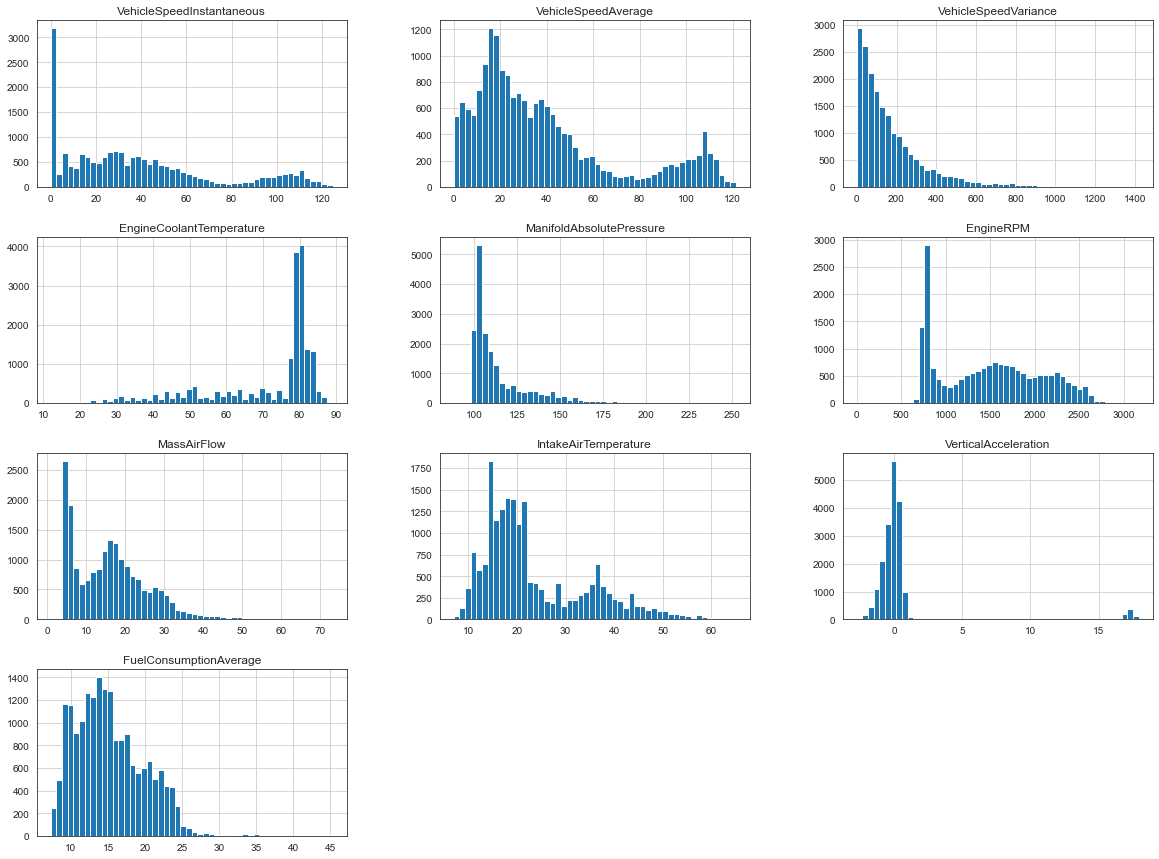

In [69]:
X_train_num.hist(bins=50, figsize=(20,15))

In [70]:
orig_dist = pd.DataFrame(X_train_num.agg(['skew', 'kurtosis']).transpose())
orig_dist = orig_dist.add_prefix('original_')
orig_dist #the skewness/kurtosis before any transformation

original_skew  original_kurtosis
VehicleSpeedInstantaneous       0.837620          -0.247995
VehicleSpeedAverage             1.099062           0.181004
VehicleSpeedVariance            2.135534           6.000058
EngineCoolantTemperature       -1.445955           1.001245
ManifoldAbsolutePressure        2.298943           6.427249
EngineRPM                       0.209905          -1.122746
MassAirFlow                     0.877312           0.901807
IntakeAirTemperature            1.071027           0.359724
VerticalAcceleration            4.573195          19.753418
FuelConsumptionAverage          0.671023           0.426473

In [71]:
X_train_to_transform = X_train[['VehicleSpeedInstantaneous',
       'VehicleSpeedAverage', 'VehicleSpeedVariance', 'EngineCoolantTemperature',
       'ManifoldAbsolutePressure', 'EngineRPM', 'MassAirFlow',
       'IntakeAirTemperature','FuelConsumptionAverage']] #taking out VerticalAcceleration because of negative values

In [72]:
df_sqrt = X_train_to_transform.applymap(lambda x: np.sqrt(x)) #getting the square root transformation

array([[<AxesSubplot:title={'center':'VehicleSpeedInstantaneous'}>,
        <AxesSubplot:title={'center':'VehicleSpeedAverage'}>,
        <AxesSubplot:title={'center':'VehicleSpeedVariance'}>],
       [<AxesSubplot:title={'center':'EngineCoolantTemperature'}>,
        <AxesSubplot:title={'center':'ManifoldAbsolutePressure'}>,
        <AxesSubplot:title={'center':'EngineRPM'}>],
       [<AxesSubplot:title={'center':'MassAirFlow'}>,
        <AxesSubplot:title={'center':'IntakeAirTemperature'}>,
        <AxesSubplot:title={'center':'FuelConsumptionAverage'}>]],
      dtype=object)

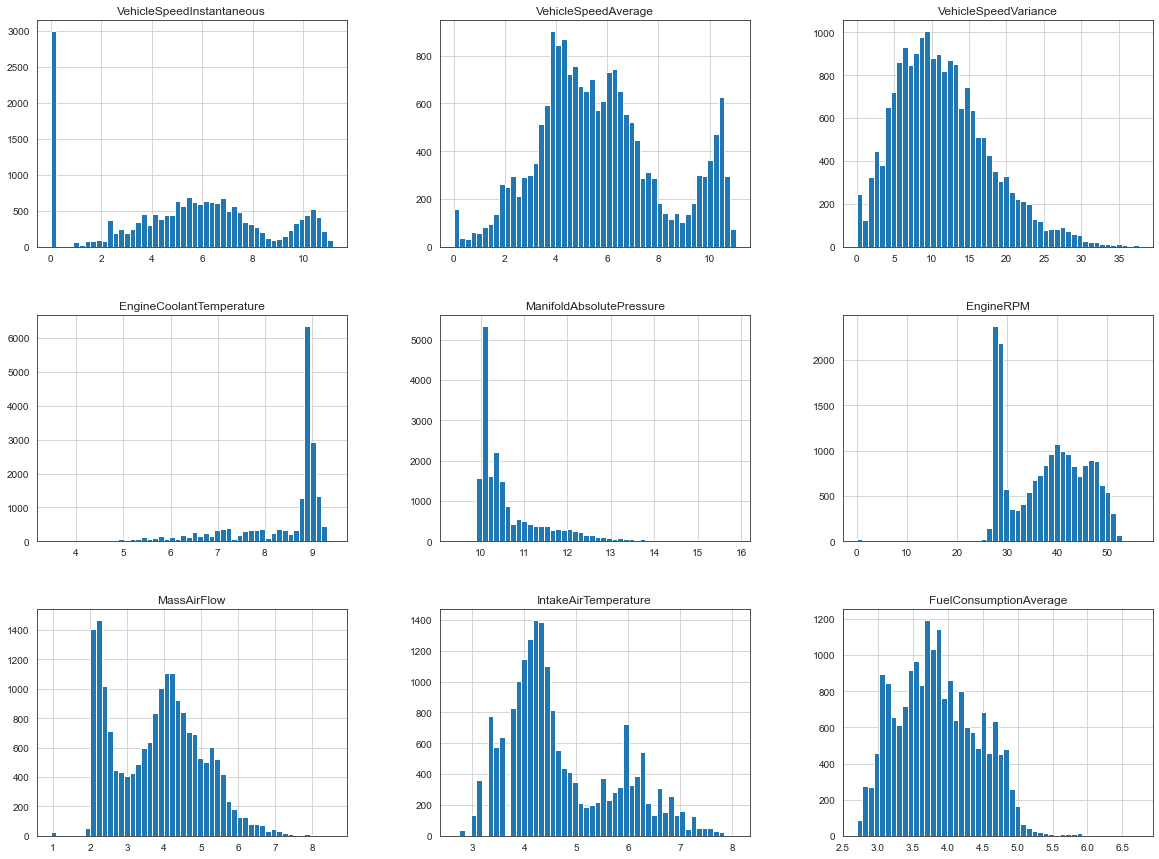

In [73]:
df_sqrt.hist(bins=50, figsize=(20,15))

In [74]:
df_log = X_train_to_transform.applymap(lambda x: np.log(x+1)) # log transformation (+1 for zero values)

array([[<AxesSubplot:title={'center':'VehicleSpeedInstantaneous'}>,
        <AxesSubplot:title={'center':'VehicleSpeedAverage'}>,
        <AxesSubplot:title={'center':'VehicleSpeedVariance'}>],
       [<AxesSubplot:title={'center':'EngineCoolantTemperature'}>,
        <AxesSubplot:title={'center':'ManifoldAbsolutePressure'}>,
        <AxesSubplot:title={'center':'EngineRPM'}>],
       [<AxesSubplot:title={'center':'MassAirFlow'}>,
        <AxesSubplot:title={'center':'IntakeAirTemperature'}>,
        <AxesSubplot:title={'center':'FuelConsumptionAverage'}>]],
      dtype=object)

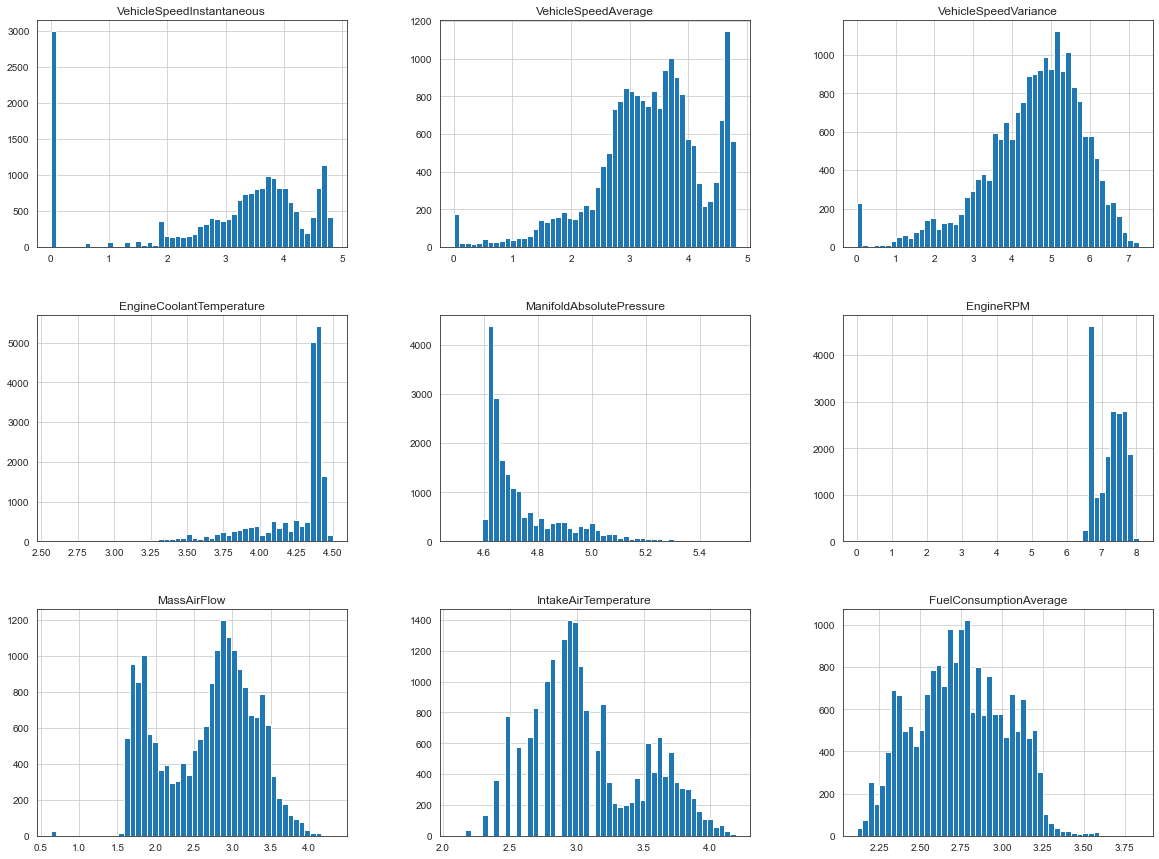

In [75]:
df_log.hist(bins=50, figsize=(20,15))

In [76]:
# EngineCoolantTemperature is negatively skewed
X_train_num['EngineCoolantTemperature'] = np.log(max(X_train_num['EngineCoolantTemperature'] + 1) - X_train_num['EngineCoolantTemperature'])

In [77]:
neg_log = pd.DataFrame(X_train_num['EngineCoolantTemperature'].agg(['skew', 'kurtosis']).transpose())
neg_log

EngineCoolantTemperature
skew                      0.672345
kurtosis                 -0.602490

<AxesSubplot:>

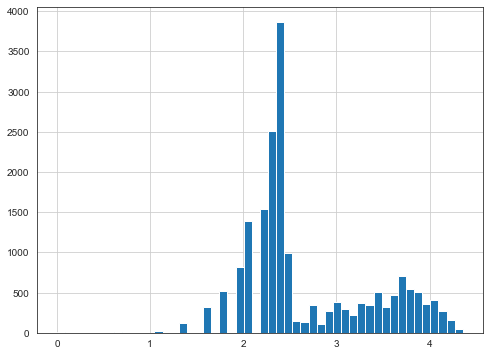

In [78]:
X_train_num['EngineCoolantTemperature'].hist(bins=50, figsize=(8,6))

In [92]:
from sklearn.preprocessing import PowerTransformer

df_power = X_train_num.copy()
pt = PowerTransformer()
df_power = pt.fit_transform(df_power)
df_power = pd.DataFrame(df_power, columns=X_train_num.columns)

array([[<AxesSubplot:title={'center':'VehicleSpeedInstantaneous'}>,
        <AxesSubplot:title={'center':'VehicleSpeedAverage'}>,
        <AxesSubplot:title={'center':'VehicleSpeedVariance'}>],
       [<AxesSubplot:title={'center':'EngineCoolantTemperature'}>,
        <AxesSubplot:title={'center':'ManifoldAbsolutePressure'}>,
        <AxesSubplot:title={'center':'EngineRPM'}>],
       [<AxesSubplot:title={'center':'MassAirFlow'}>,
        <AxesSubplot:title={'center':'IntakeAirTemperature'}>,
        <AxesSubplot:title={'center':'VerticalAcceleration'}>],
       [<AxesSubplot:title={'center':'FuelConsumptionAverage'}>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

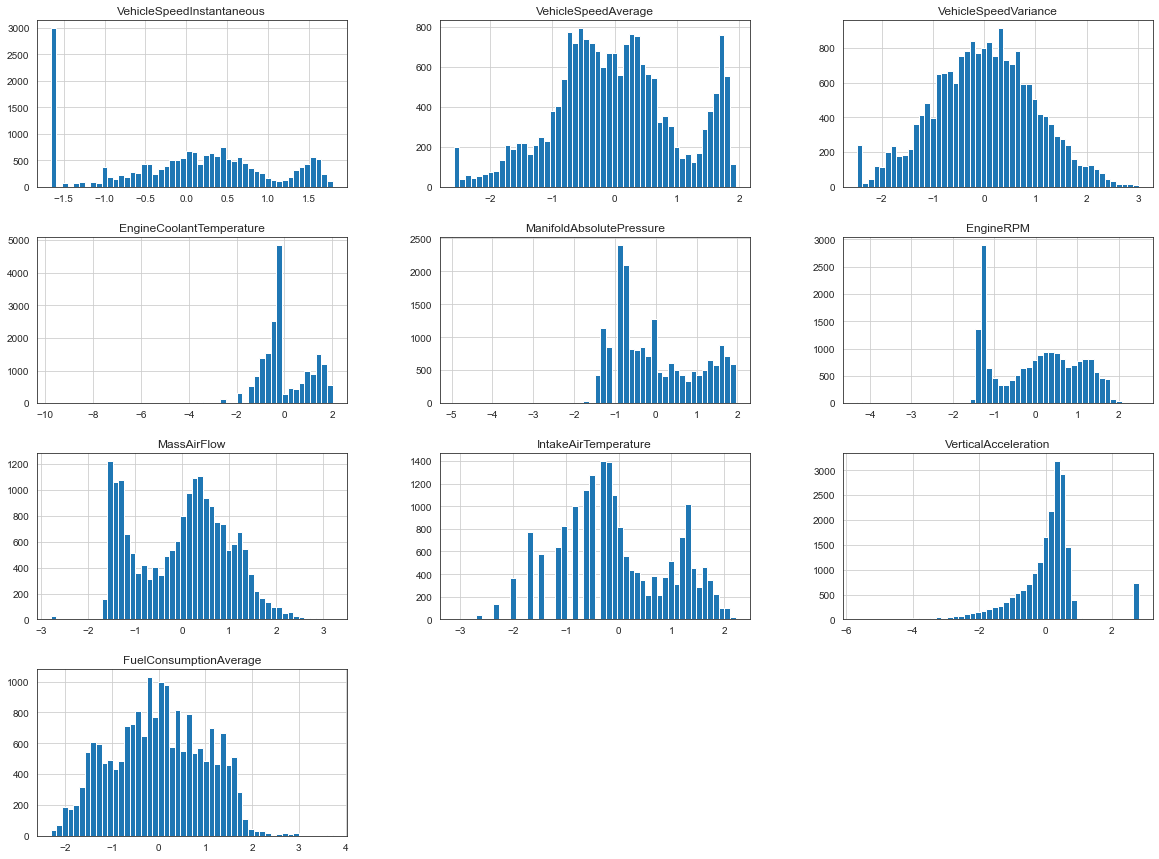

In [89]:
df_power.hist(bins=50, figsize=(20,15))

In [81]:
sqrt_dist = pd.DataFrame(df_sqrt.agg(['skew', 'kurtosis']).transpose())
sqrt_dist = sqrt_dist.add_prefix('sqrt_')
log_dist = pd.DataFrame(df_log.agg(['skew', 'kurtosis']).transpose())
log_dist = log_dist.add_prefix('log_')
power_dist = pd.DataFrame(df_power.agg(['skew', 'kurtosis']).transpose())
power_dist = power_dist.add_prefix('power_')
compare_tab = pd.concat([orig_dist, sqrt_dist, log_dist, power_dist], axis=1)
compare_tab

original_skew  original_kurtosis  sqrt_skew  \
VehicleSpeedInstantaneous       0.837620          -0.247995  -0.206263   
VehicleSpeedAverage             1.099062           0.181004   0.341360   
VehicleSpeedVariance            2.135534           6.000058   0.730340   
EngineCoolantTemperature       -1.445955           1.001245  -1.691743   
ManifoldAbsolutePressure        2.298943           6.427249   2.003956   
EngineRPM                       0.209905          -1.122746  -0.124027   
MassAirFlow                     0.877312           0.901807   0.213216   
IntakeAirTemperature            1.071027           0.359724   0.719197   
VerticalAcceleration            4.573195          19.753418        NaN   
FuelConsumptionAverage          0.671023           0.426473   0.323957   

                           sqrt_kurtosis  log_skew  log_kurtosis  power_skew  \
VehicleSpeedInstantaneous      -0.773965 -1.033898     -0.148287   -0.224737   
VehicleSpeedAverage            -0.419481 -0.824222      1.159783   -0.023818   
VehicleSpeedVariance            0.488030 -0.945327      1.278815   -0.025494   
EngineCoolantTemperature        2.132041 -2.024195      4.004231   -0.035853   
ManifoldAbsolutePressure        4.456045  1.763050      3.048469    0.469551   
EngineRPM                      -0.664212 -4.172463     59.059662   -0.050869   
MassAirFlow                    -0.632682 -0.245412     -0.935487   -0.041334   
IntakeAirTemperature           -0.349151  0.380846     -0.669552    0.044870   
VerticalAcceleration                 NaN       NaN           NaN   -0.651690   
FuelConsumptionAverage         -0.401449  0.055133     -0.683098    0.005875   

                           power_kurtosis  
VehicleSpeedInstantaneous       -0.842931  
VehicleSpeedAverage             -0.336328  
VehicleSpeedVariance            -0.193920  
EngineCoolantTemperature         2.036621  
ManifoldAbsolutePressure        -1.058764  
EngineRPM                       -0.923728  
MassAirFlow                     -0.898636  
IntakeAirTemperature            -0.671133  
VerticalAcceleration             4.254750  
FuelConsumptionAverage          -0.704331

PowerTransformer seems to be the most effective transform for reducing skewness for all columns (although it does increase kurtosis for `VehicleSpeedInstantaneous`, `EngineCoolantTemperature`, `IntakeAirTemperature` and `FuelConsumptionAverage`.)

In [82]:
for column in df_power:
    z = np.abs(st.zscore(df_power[column])) # getting the z-scores for all columns.
    print(column)
    print(np.where(z > 3)) #checking if there are any outliers with a z-score > 3

VehicleSpeedInstantaneous
(array([], dtype=int64),)
VehicleSpeedAverage
(array([], dtype=int64),)
VehicleSpeedVariance
(array([  505,  1469, 16768], dtype=int64),)
EngineCoolantTemperature
(array([], dtype=int64),)
ManifoldAbsolutePressure
(array([], dtype=int64),)
EngineRPM
(array([], dtype=int64),)
MassAirFlow
(array([], dtype=int64),)
IntakeAirTemperature
(array([], dtype=int64),)
VerticalAcceleration
(array([   38,   122,   129,   435,   643,   654,   727,   775,   780,
         892,   956,   977,   979,   999,  1178,  1299,  1307,  1347,
        1396,  1517,  1528,  1551,  1556,  1689,  1705,  1767,  1792,
        1953,  1985,  2107,  2167,  2260,  2267,  2378,  2382,  2474,
        2506,  2546,  2598,  2841,  3260,  3356,  3507,  3528,  3579,
        3605,  3797,  3812,  3849,  4005,  4037,  4067,  4070,  4198,
        4335,  4351,  4462,  4487,  4491,  4541,  4592,  4603,  4792,
        4806,  4859,  4862,  4868,  4900,  4990,  5015,  5071,  5114,
        5122,  5174,  5197,  54

PowerTransform has removed most of the outliers in the `VehicleSpeedVariance` column but most of the outliers in the `VerticalAcceleration` column remain, maybe we could try removing this feature (or just the outliers) later to see if the outliers have an effect on the model.

#### Preprocessing Pipeline

In [84]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer


cat_col = ['traffic']

# Build numeric processor
num_cols = ['VehicleSpeedInstantaneous', 'VehicleSpeedAverage',
       'VehicleSpeedVariance', 'EngineCoolantTemperature',
       'ManifoldAbsolutePressure', 'EngineRPM', 'MassAirFlow',
       'IntakeAirTemperature', 'VerticalAcceleration',
       'FuelConsumptionAverage']

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('power_transform', PowerTransformer()),
    ('std_scaler', StandardScaler())
])

prep_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_cols),
    ("cat", OneHotEncoder(), cat_col)
])


In [85]:
X_train.shape

(19020, 11)

In [88]:
X_test.shape

(4755, 11)

In [93]:
X_train_prepared = prep_pipeline.fit_transform(X_train)
print(X_train_prepared.shape)

(19020, 13)


In [94]:
X_test_prepared = prep_pipeline.transform(X_test)
print(X_test_prepared.shape)

(4755, 13)


### Multi-Class Classification Models

From here you can experiment with your own models, or work on some of the other versions of SVM.



#### Finding best hyperparameters for SVC with GridSearchCV

In [95]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import classification_report

In [96]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, GridSearchCV

# Create the parameter grid 
params_grid = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4], 'C': [1, 10, 100, 1000]},
               {'kernel':['poly'], 'C': [1, 10, 100, 1000]},
               {'kernel':['sigmoid'], 'C': [1, 10, 100, 1000]},
               {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

In [97]:
# Performing CV to tune parameters for best SVM fit 
svm_model = GridSearchCV(SVC(), params_grid, cv=5)
svm_model.fit(X_train_prepared, y_train)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid=[{'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001],
                          'kernel': ['rbf']},
                         {'C': [1, 10, 100, 1000], 'kernel': ['poly']},
                         {'C': [1, 10, 100, 1000], 'kernel': ['sigmoid']},
                         {'C': [1, 10, 100, 1000], 'kernel': ['linear']}])

In [98]:
# View the accuracy score
print('Best score for training data:', svm_model.best_score_,"\n") 

# View the best parameters for the model found using grid search
print('Best C:',svm_model.best_estimator_.C,"\n") 
print('Best Kernel:',svm_model.best_estimator_.kernel,"\n")
print('Best Gamma:',svm_model.best_estimator_.gamma,"\n")

Best score for training data: 0.9810725552050472 

Best C: 1000 

Best Kernel: poly 

Best Gamma: scale 



In [102]:
final_model = svm_model.best_estimator_
train_pred = final_model.predict(X_train_prepared)
final_model.score(X_train_prepared, y_train)

0.9942691903259726

In [103]:
# Making the confusion matrix for training set
train_cm = confusion_matrix(y_train, train_pred)
train_cm_df = pd.DataFrame(train_cm.T, index=final_model.classes_, columns=final_model.classes_)
print(train_cm_df)

                      FullOfHolesCondition  SmoothCondition  UnevenCondition
FullOfHolesCondition                  2577               43                7
SmoothCondition                         13            11332               22
UnevenCondition                          9               15             5002


In [104]:
# printing classification report for training set
print(classification_report(y_train, train_pred))

                      precision    recall  f1-score   support

FullOfHolesCondition       0.98      0.99      0.99      2599
     SmoothCondition       1.00      0.99      1.00     11390
     UnevenCondition       1.00      0.99      0.99      5031

            accuracy                           0.99     19020
           macro avg       0.99      0.99      0.99     19020
        weighted avg       0.99      0.99      0.99     19020



In [135]:
# final testing
test_pred = final_model.predict(X_test_prepared)

In [136]:
# Making the confusion matrix and classification report for testing set
test_cm = confusion_matrix(y_test, test_pred)
test_cm_df = pd.DataFrame(test_cm.T, index=final_model.classes_, columns=final_model.classes_)
print(test_cm_df)
print("\n")
print(classification_report(y_test, test_pred))

print("Training set score for SVM (best estimators): %f" % final_model.score(X_train_prepared , y_train))
print("Testing  set score for SVM (best estimators): %f" % final_model.score(X_test_prepared  , y_test ))


                      FullOfHolesCondition  SmoothCondition  UnevenCondition
FullOfHolesCondition                   630               36                6
SmoothCondition                          5             2799               20
UnevenCondition                         15               12             1232


                      precision    recall  f1-score   support

FullOfHolesCondition       0.94      0.97      0.95       650
     SmoothCondition       0.99      0.98      0.99      2847
     UnevenCondition       0.98      0.98      0.98      1258

            accuracy                           0.98      4755
           macro avg       0.97      0.98      0.97      4755
        weighted avg       0.98      0.98      0.98      4755

Training set score for SVM (best estimators): 0.994269
Testing  set score for SVM (best estimators): 0.980231


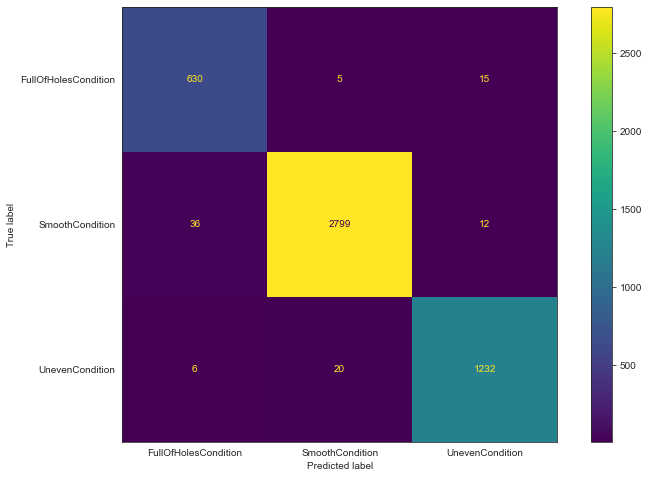

In [140]:
# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(12, 8))

cmp = ConfusionMatrixDisplay(test_cm, display_labels=final_model.classes_)
cmp.plot(ax=ax)


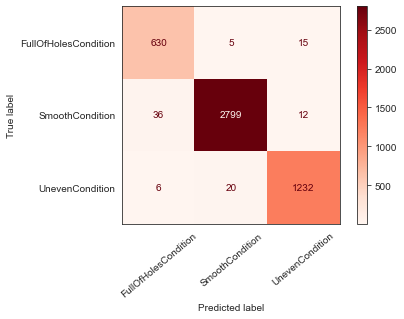

In [138]:
# Plot the confusion matrix (another style)
cmp = ConfusionMatrixDisplay(test_cm, display_labels=final_model.classes_)
cmp = cmp.plot(include_values=True, cmap="Reds", ax=None, xticks_rotation=40)

The first time I ran GridSearchCV I got the below best estimators (but I only searched using the linear and rbf kernels). 

In [113]:
#building a model with the best hyperparameters I got first time I ran GridSearchCV

rbf = SVC(kernel='rbf', gamma=0.001, C=1000).fit(X_train_prepared, y_train) 

In [114]:
rbf.score(X_train_prepared, y_train)

0.9246056782334385

In [116]:
rbf_pred = rbf.predict(X_train_prepared)

rbf_cm = confusion_matrix(y_train, rbf_pred)
rbf_cm_df = pd.DataFrame(rbf_cm.T, index=rbf.classes_, columns=rbf.classes_)
print(rbf_cm_df)
print(classification_report(y_train, rbf_pred))

                      FullOfHolesCondition  SmoothCondition  UnevenCondition
FullOfHolesCondition                  2217              237              119
SmoothCondition                        174            10732              275
UnevenCondition                        208              421             4637
                      precision    recall  f1-score   support

FullOfHolesCondition       0.86      0.85      0.86      2599
     SmoothCondition       0.96      0.94      0.95     11390
     UnevenCondition       0.88      0.92      0.90      5031

            accuracy                           0.92     19020
           macro avg       0.90      0.91      0.90     19020
        weighted avg       0.93      0.92      0.92     19020



In [118]:
# final testing
test_pred = rbf.predict(X_test_prepared)

# Making the confusion matrix and classification report for testing set
test_cm = confusion_matrix(y_test, test_pred)
test_cm_df = pd.DataFrame(test_cm.T, index=rbf.classes_, columns=rbf.classes_)
print(test_cm_df)
print("\n")
print(classification_report(y_test, test_pred))

print("Training set score for SVM(rbf): %f" % rbf.score(X_train_prepared , y_train))
print("Testing  set score for SVM(rbf): %f" % rbf.score(X_test_prepared  , y_test ))


                      FullOfHolesCondition  SmoothCondition  UnevenCondition
FullOfHolesCondition                   530               73               25
SmoothCondition                         47             2671               86
UnevenCondition                         73              103             1147


                      precision    recall  f1-score   support

FullOfHolesCondition       0.84      0.82      0.83       650
     SmoothCondition       0.95      0.94      0.95      2847
     UnevenCondition       0.87      0.91      0.89      1258

            accuracy                           0.91      4755
           macro avg       0.89      0.89      0.89      4755
        weighted avg       0.92      0.91      0.91      4755

Training set score for SVM(rbf): 0.924606
Testing  set score for SVM(rbf): 0.914406


<Figure size 864x432 with 0 Axes>

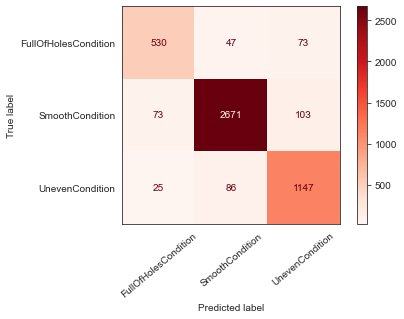

In [130]:
# Plot the confusion matrix
cmp = ConfusionMatrixDisplay(test_cm, display_labels=rbf.classes_)
cmp = cmp.plot(include_values=True, cmap="Reds", ax=None, xticks_rotation=40)

Trying out LinearSVC(multi_class='crammer_singer')

In [121]:
from sklearn.svm import LinearSVC

linear_svc = LinearSVC(C=1000, multi_class='crammer_singer')
linear_svc.fit(X_train_prepared,y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


LinearSVC(C=1000, multi_class='crammer_singer')

In [122]:
linear_svc_preds = linear_svc.predict(X_train_prepared)
linear_svc.score(X_train_prepared, y_train)

0.8215562565720295

In [141]:
#confustion matrix for training set
linear_svc_cm = confusion_matrix(y_train, linear_svc_preds)
linear_svc_cm_train_df = pd.DataFrame(linear_svc_cm.T, index=linear_svc.classes_, columns=linear_svc.classes_)
print(linear_svc_cm_train_df)

                      FullOfHolesCondition  SmoothCondition  UnevenCondition
FullOfHolesCondition                  1904              461              315
SmoothCondition                        342             9521              515
UnevenCondition                        353             1408             4201


In [142]:
#classification report for training set
print(classification_report(y_train, linear_svc_preds))

                      precision    recall  f1-score   support

FullOfHolesCondition       0.71      0.73      0.72      2599
     SmoothCondition       0.92      0.84      0.87     11390
     UnevenCondition       0.70      0.84      0.76      5031

            accuracy                           0.82     19020
           macro avg       0.78      0.80      0.79     19020
        weighted avg       0.83      0.82      0.82     19020



In [143]:
#testing
linear_svc_preds_test = linear_svc.predict(X_test_prepared)
linear_svc.score(X_test_prepared, y_test)

linear_svc_cm_test = confusion_matrix(y_test, linear_svc_preds_test)
linear_svc_cm_df_test = pd.DataFrame(linear_svc_cm_test.T, index=linear_svc.classes_, columns=linear_svc.classes_)
print(linear_svc_cm_df_test )

                      FullOfHolesCondition  SmoothCondition  UnevenCondition
FullOfHolesCondition                   462              129               70
SmoothCondition                         96             2370              144
UnevenCondition                         92              348             1044


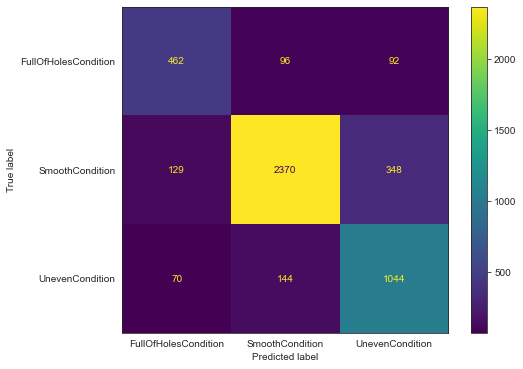

In [145]:
# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))

cmp = ConfusionMatrixDisplay(linear_svc_cm_test, display_labels=linear_svc.classes_)
cmp.plot(ax=ax)

Trying out PCA - not sure if this is relevant or helpful, but I just copied and pasted this code in from a different notebook to play around with it. We can delete from the final notebook.

In [146]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

principalComponents = pca.fit_transform(X_train_prepared)

In [147]:
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
principalDf.head(5)

principal component 1  principal component 2
0              -3.961638               0.928042
1              -0.897501               0.513570
2              -0.973728              -0.301350
3               1.614267              -2.055888
4              -1.000150               0.953912

In [148]:
y_train.reset_index(inplace=True, drop=True)

In [149]:
finalDf = pd.concat([principalDf, y_train], axis = 1)
finalDf.head(5)

principal component 1  principal component 2           roadSurface
0              -3.961638               0.928042       SmoothCondition
1              -0.897501               0.513570       SmoothCondition
2              -0.973728              -0.301350  FullOfHolesCondition
3               1.614267              -2.055888       UnevenCondition
4              -1.000150               0.953912       UnevenCondition

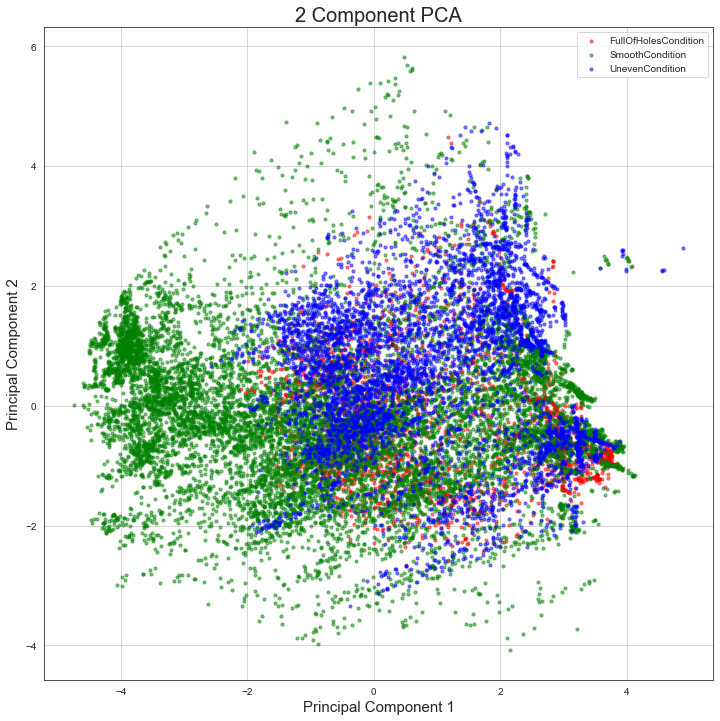

In [150]:
fig = plt.figure(figsize = (12,12))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 Component PCA', fontsize = 20)


targets = ['FullOfHolesCondition', 'SmoothCondition', 'UnevenCondition']
colors = ['r', 'g', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['roadSurface'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 10, alpha=0.5)
ax.legend(targets)
ax.grid()

In [151]:
pca.explained_variance_ratio_

array([0.44536182, 0.16444725])

<AxesSubplot:xlabel='PC'>

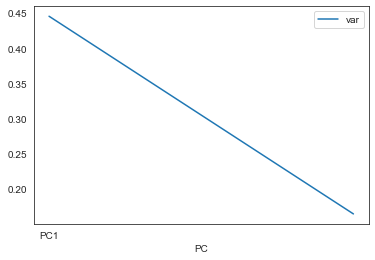

In [152]:
# Scree plot
pcdf = pd.DataFrame({'var':pca.explained_variance_ratio_, 'PC':['PC1','PC2']})
pcdf.plot(y = "var", x = "PC")

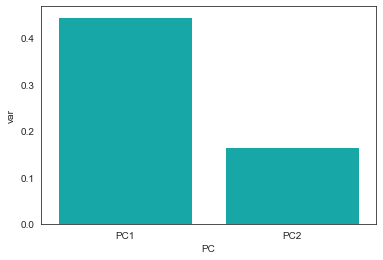

In [153]:
sns.barplot(x='PC',y="var", data=pcdf, color="c");

In [154]:
print(abs(pca.components_))

[[0.42837107 0.37872474 0.03671641 0.18808891 0.4181924  0.41993892
  0.41205799 0.15664218 0.03314043 0.280967   0.0611387  0.08121751
  0.02007881]
 [0.07745749 0.15176846 0.01713545 0.28414361 0.1546457  0.21662511
  0.24779273 0.46811212 0.5766357  0.45379529 0.00398775 0.00909218
  0.00510443]]


In [155]:
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(X_train_prepared)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2', 'principal component 3'])
principalDf.head(5)

finalDf = pd.concat([principalDf, y_train], axis = 1)
finalDf.head(5)

principal component 1  principal component 2  principal component 3  \
0              -3.961638               0.928042              -1.730322   
1              -0.897501               0.513570              -0.103955   
2              -0.973728              -0.301350              -0.733627   
3               1.614267              -2.055888              -0.501320   
4              -1.000150               0.953912               0.446800   

            roadSurface  
0       SmoothCondition  
1       SmoothCondition  
2  FullOfHolesCondition  
3       UnevenCondition  
4       UnevenCondition

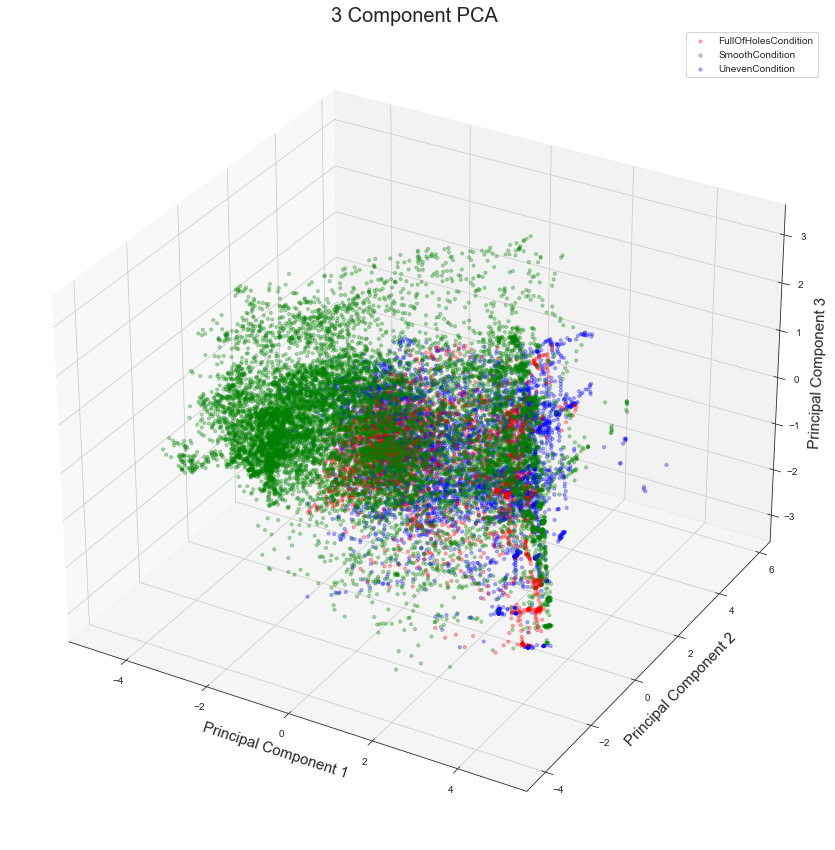

In [156]:
# Visualise
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize = (15,15))
ax = fig.add_subplot(111, projection='3d') 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_zlabel('Principal Component 3', fontsize = 15)
ax.set_title('3 Component PCA', fontsize = 20)

targets = ['FullOfHolesCondition', 'SmoothCondition', 'UnevenCondition']
colors = ['r', 'g', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['roadSurface'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , finalDf.loc[indicesToKeep, 'principal component 3']
               , c = color
               , s = 10, alpha=0.3)
ax.legend(targets)
ax.grid()

In [157]:
pca.explained_variance_ratio_

array([0.44536182, 0.16444725, 0.10761286])

In [158]:
pca = PCA(n_components=6)
principalComponents = pca.fit_transform(X_train_prepared)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2', 
                          'principal component 3', 'principal component 4', 'principal component 5', 
                          'principal component 6'])
principalDf.head(5)

finalDf = pd.concat([principalDf, y_train], axis = 1)
finalDf.head(5)

principal component 1  principal component 2  principal component 3  \
0              -3.961638               0.928042              -1.730322   
1              -0.897501               0.513570              -0.103955   
2              -0.973728              -0.301350              -0.733627   
3               1.614267              -2.055888              -0.501320   
4              -1.000150               0.953912               0.446800   

   principal component 4  principal component 5  principal component 6  \
0               0.174682               0.457642              -0.072257   
1              -0.588565               0.739569               0.020870   
2               2.175090               0.492271               0.144346   
3               1.342849               0.114951              -0.218490   
4               0.007957              -1.157375              -0.266387   

            roadSurface  
0       SmoothCondition  
1       SmoothCondition  
2  FullOfHolesCondition  
3       UnevenCondition  
4       UnevenCondition

In [159]:
pca.explained_variance_ratio_

array([0.44536182, 0.16444725, 0.10761286, 0.0879347 , 0.06144034,
       0.04591745])

In [160]:
# We already know that there are 3 types of road surfaces, so let's set the number of clusters = 3 and see
# if the predictions for each data point matches the label in y.

from sklearn.cluster import KMeans

nclusters = 3 # this is the k in kmeans
seed = 0 # seed is set to reproduce the prediction output/results

km = KMeans(n_clusters=nclusters, random_state=seed)
km.fit(X_train_prepared)

# predict the cluster for each data point
y_cluster_kmeans = km.predict(X_train_prepared)
y_cluster_kmeans

array([1, 2, 2, ..., 0, 2, 2])

In [161]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X_train_prepared)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
principalDf.head(5)

principal component 1  principal component 2
0              -3.961638               0.928042
1              -0.897501               0.513570
2              -0.973728              -0.301350
3               1.614267              -2.055888
4              -1.000150               0.953912

In [162]:
# first, convert road surface to an arbitrary number
target = y_train.astype('category') 
y_array = target.cat.codes

df_plot = principalDf.copy()
df_plot['ClusterKmeans'] = y_cluster_kmeans
df_plot['roadSurface'] = y_array  # also add actual labels so we can use it in later plots
df_plot.head(10)

principal component 1  principal component 2  ClusterKmeans  roadSurface
0              -3.961638               0.928042              1            1
1              -0.897501               0.513570              2            1
2              -0.973728              -0.301350              2            0
3               1.614267              -2.055888              0            2
4              -1.000150               0.953912              2            2
5              -3.189095               0.073910              1            1
6              -1.069151               0.176780              2            0
7              -4.394459               0.333738              1            1
8               1.126198              -0.422078              2            0
9              -1.522890              -1.079651              2            1

In [163]:
# so now we can make a 2d scatterplot of the clusters
# first define a plot fn

def plotData(df, groupby):
    "make a scatterplot of the first two principal components of the data, colored by the groupby field"
    
    # make a figure with just one subplot.
    # you can specify multiple subplots in a figure, 
    # in which case ax would be an array of axes,
    # but in this case it'll just be a single axis object.
    fig, ax = plt.subplots(figsize = (12,12))

    # color map
    cmap = mpl.cm.get_cmap('prism')

    for i, cluster in df.groupby(groupby):
        cluster.plot(ax = ax, # need to pass this so all scatterplots are on same graph
                     kind = 'scatter', 
                     x = 'principal component 1', y = 'principal component 2',
                     color = cmap(i/(nclusters-1)), # cmap maps a number to a color
                     label = "%s %i" % (groupby, i), 
                     s=30) # dot size
    ax.grid()
    ax.axhline(0, color='black')
    ax.axvline(0, color='black')
    ax.set_title("Principal Components Analysis (PCA) of Road Surface Condition Dataset");

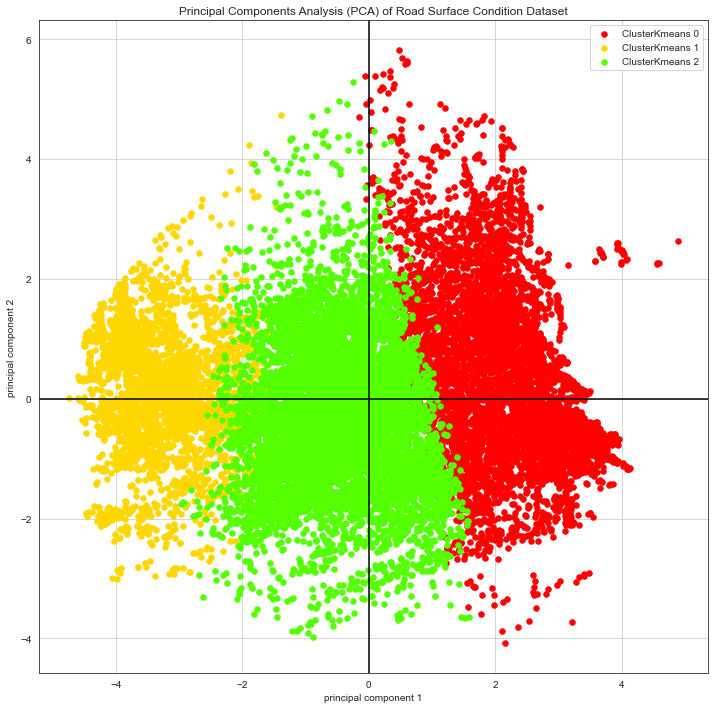

In [164]:
# plot the clusters each datapoint was assigned to
import matplotlib as mpl
plotData(df_plot, 'ClusterKmeans')

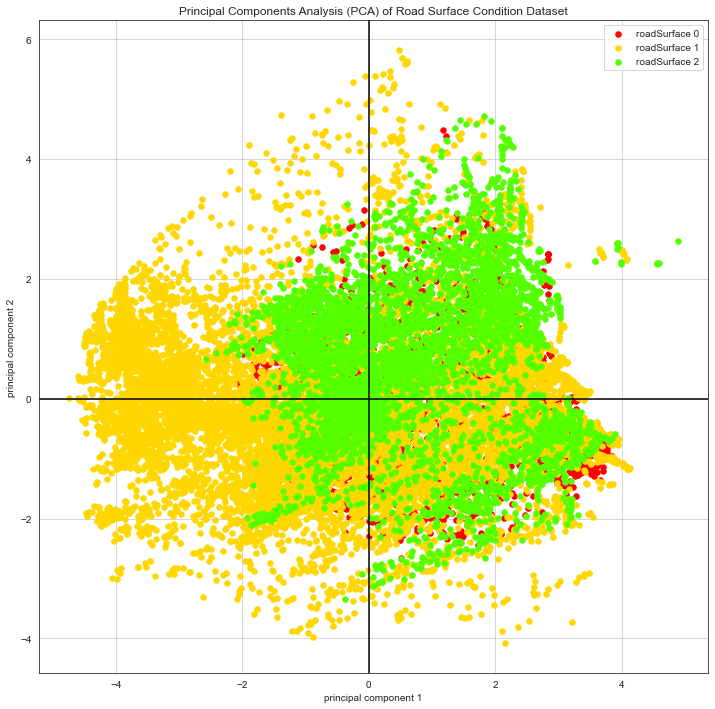

In [165]:
plotData(df_plot, 'roadSurface')

In [166]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=nclusters)
gmm.fit(X_train_prepared)

# predict the cluster for each data point
y_cluster_gmm = gmm.predict(X_train_prepared)
y_cluster_gmm

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

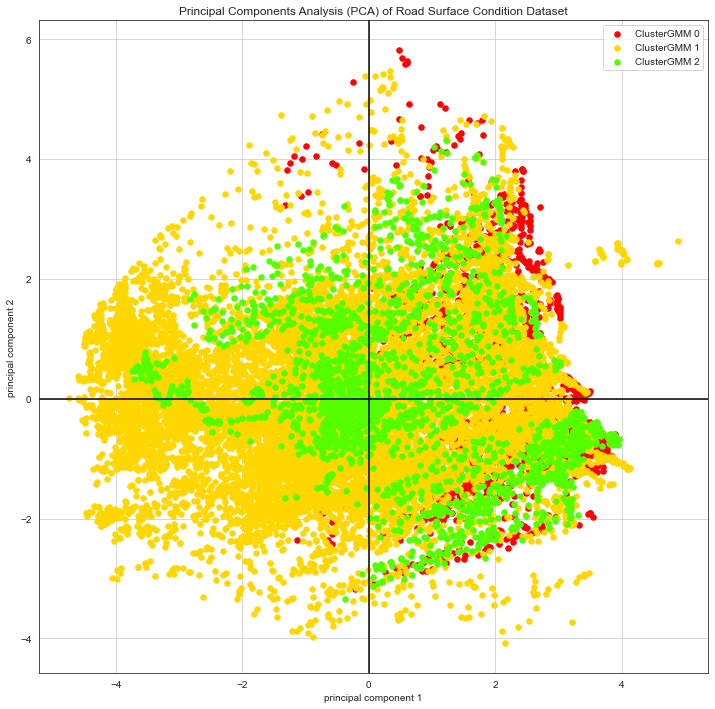

In [167]:
# add the GMM clusters to our data table and plot them
df_plot['ClusterGMM'] = y_cluster_gmm
plotData(df_plot, 'ClusterGMM')

In [168]:
from sklearn.metrics.cluster import adjusted_rand_score

# let's see how the k-means clustering score - 
score = adjusted_rand_score(y_array, y_cluster_kmeans)
score

0.006444025423401454

In [169]:
# Check the clustering score for GMM
score = adjusted_rand_score(y_array, y_cluster_gmm)
score

0.23364350061523642